# TFM - SHAP 

Using the Shap and a CNN previously developped for Deep Learning:

+ Developing a CNN model to classify X-ray images with high accuracy.
+ To explore classifier explanation methods.

In [1]:
import numpy as np 
import pandas as pd 

import os
import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers, optimizers, applications
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,Conv2D,MaxPooling2D,GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Multiply, Dot, Concatenate, Input, UpSampling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from sklearn.metrics import classification_report

from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot


In [2]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [3]:
def format_set(X_train, X_cv, X_test, img_width = 224, img_height = 224,grayscale = False):
    from tensorflow.keras import backend as K

    if K.image_data_format() == 'channels_first':
        if grayscale == False:      
#             input_shape = (3, img_width, img_height)
            X_train=X_train.reshape(X_train.shape[0],3,img_width,img_height)
            X_cv=X_cv.reshape(X_cv.shape[0],3,img_width,img_height)
            X_test=X_test.reshape(X_test.shape[0],3,img_width,img_height)
        else:
            X_train=X_train.reshape(X_train.shape[0],1,img_width,img_height)
            X_cv=X_cv.reshape(X_cv.shape[0],1,img_width,img_height)
            X_test=X_test.reshape(X_test.shape[0],1,img_width,img_height)
    else:
        if grayscale == False:      
    #         input_shape = (img_width, img_height, 3)
            X_train=X_train.reshape(X_train.shape[0],img_width,img_height,3)
            X_cv=X_cv.reshape(X_cv.shape[0],img_width,img_height,3)
            X_test=X_test.reshape(X_test.shape[0],img_width,img_height,3)
        else:
            X_train=X_train.reshape(X_train.shape[0],img_width,img_height,1)
            X_cv=X_cv.reshape(X_cv.shape[0],img_width,img_height,1)
            X_test=X_test.reshape(X_test.shape[0],img_width,img_height,1)

    return X_train, X_cv, X_test

In [4]:
def gray(Im):
    '''Get greyscale images'''
    return np.dot(Im, [0.2989, 0.5870, 0.1140]) #By definition of Pillow

In [5]:
def image_load(directory, filename,sizeh = 224,sizev = 224,grayscale = False):
    '''Join directory and filename, load image, reshape to sizeh,sizev and normalize'''
    filename=os.path.join(directory, filename)
    if grayscale == False:
        im=tf.keras.preprocessing.image.load_img(filename,target_size=(sizeh, sizev)) #Full name to avoid variable interference
        im=np.reshape(im,(sizeh,sizev,3))
    else:
        im=tf.keras.preprocessing.image.load_img(filename,target_size=(sizeh, sizev),color_mode = 'grayscale')
        im=np.reshape(im,(sizeh,sizev))
    im=im.astype('float32') / 255
    return im

In [6]:
def not_super_cropper(X, hcrop = 19,vcrop = 19,generate = 5,flip_rate = 0.5,use_list = False, grayscale = False):
    '''For labels, pass data first and label second, as a list - grayscale images are (224,224)'''
    images = []
    if use_list == True: 
        labels = []
    hgenerate,vgenerate = min(generate,hcrop), min(generate,vcrop)
    hpos,vpos = np.random.choice(hcrop,hgenerate,replace = False), np.random.choice(vcrop,vgenerate,replace = True) #set replace to true, to be sure to generate enough values
    for i in range(hgenerate):
        if type(X) == list and use_list == True:
            X_black = np.zeros(X.shape) #Background
            Label_black = np.zeros(X.shape) #Label background
            if grayscale == False:
                X_crop = X[0][hpos[i]:hpos[i]+(X[0].shape[0]-hcrop),vpos[i]:vpos[i]+(X[0].shape[1]-vcrop),:]
                X_black[hpos[i]:hpos[i]+(X[0].shape[0]-hcrop),vpos[i]:vpos[i]+(X[0].shape[1]-vcrop),:] = X_crop
                Label_crop = X[1][hpos[i]:hpos[i]+(X[1].shape[0]-hcrop),vpos[i]:vpos[i]+(X[1].shape[1]-vcrop),:]
                Label_black[hpos[i]:hpos[i]+(X[1].shape[0]-hcrop),vpos[i]:vpos[i]+(X[1].shape[1]-vcrop),:] = Label_crop
            else:
                X_crop = X[0][hpos[i]:hpos[i]+(X[0].shape[0]-hcrop),vpos[i]:vpos[i]+(X[0].shape[1]-vcrop)]
                X_black[hpos[i]:hpos[i]+(X[0].shape[0]-hcrop),vpos[i]:vpos[i]+(X[0].shape[1]-vcrop)] = X_crop
                Label_crop = X[1][hpos[i]:hpos[i]+(X[1].shape[0]-hcrop),vpos[i]:vpos[i]+(X[1].shape[1]-vcrop)]
                Label_black[hpos[i]:hpos[i]+(X[1].shape[0]-hcrop),vpos[i]:vpos[i]+(X[1].shape[1]-vcrop)] = Label_crop
            rd_flip = np.random.rand(1) #Choose to flip
            if rd_flip <= flip_rate:
                X_black = np.flipud(X_black)
                Label_black = np.flipud(Label_black)
            images.append(X_black),labels.append(Label_black)            
        else:
            X_black = np.zeros(X.shape) #Background
            if grayscale == False:
                X_crop = X[hpos[i]:hpos[i]+(X.shape[0]-hcrop),vpos[i]:vpos[i]+(X.shape[1]-vcrop),:]
                X_black[hpos[i]:hpos[i]+(X.shape[0]-hcrop),vpos[i]:vpos[i]+(X.shape[1]-vcrop),:] = X_crop
            else:
                X_crop = X[hpos[i]:hpos[i]+(X.shape[0]-hcrop),vpos[i]:vpos[i]+(X.shape[1]-vcrop)]
                X_black[hpos[i]:hpos[i]+(X.shape[0]-hcrop),vpos[i]:vpos[i]+(X.shape[1]-vcrop)] = X_crop
            rd_flip = np.random.rand(1) #Choose to flip
            if rd_flip <= flip_rate:
                X_black = np.flipud(X_black)
            images.append(X_black)
    if use_list == True:
        return images, labels #return 2 lists
    else:
        return images #return list

In [7]:
def super_cropper(X, hcrop = 19,vcrop = 19,generate = 5,flip_rate = 0.5,use_list = False, grayscale = False):
    '''For labels, pass data first and label second, as a list - grayscale images are (224,224)'''
    images = []
    if use_list == True: 
        labels = []
    hgenerate,vgenerate = min(generate,hcrop), min(generate,vcrop)
    hpos,vpos = np.random.choice(hcrop,hgenerate,replace = False), np.random.choice(vcrop,vgenerate,replace = True) #set replace to true, to be sure to generate enough values
    for i in range(hgenerate):
        if type(X) == list and use_list == True:
            if grayscale == False:
                X_crop = X[0][hpos[i]:hpos[i]+(X[0].shape[0]-hcrop),vpos[i]:vpos[i]+(X[0].shape[1]-vcrop),:]
                Label_crop = X[1][hpos[i]:hpos[i]+(X[1].shape[0]-hcrop),vpos[i]:vpos[i]+(X[1].shape[1]-vcrop),:]
            else:
                X_crop = X[0][hpos[i]:hpos[i]+(X[0].shape[0]-hcrop),vpos[i]:vpos[i]+(X[0].shape[1]-vcrop)]
                Label_crop = X[1][hpos[i]:hpos[i]+(X[1].shape[0]-hcrop),vpos[i]:vpos[i]+(X[1].shape[1]-vcrop)]
            rd_flip = np.random.rand(1) #Choose to flip
            if rd_flip <= flip_rate:
                X_crop = np.flipud(X_crop)
                Label_crop = np.flipud(Label_crop)
            images.append(X_crop),labels.append(Label_crop)            
        else:
            if grayscale == False:
                X_crop = X[hpos[i]:hpos[i]+(X.shape[0]-hcrop),vpos[i]:vpos[i]+(X.shape[1]-vcrop),:]
            else:
                X_crop = X[hpos[i]:hpos[i]+(X.shape[0]-hcrop),vpos[i]:vpos[i]+(X.shape[1]-vcrop)]
            rd_flip = np.random.rand(1) #Choose to flip
            if rd_flip <= flip_rate:
                X_crop = np.flipud(X_crop)
            images.append(X_crop)
    if use_list == True:
        return images, labels #return 2 lists
    else:
        return images #return list

In [8]:
def generate_confusion_matrix(y_full_test,yhat_full_test):
    print(classification_report(y_full_test,yhat_full_test))
    C = confusion_matrix(y_full_test,yhat_full_test)
    
    # count of true negatives is [0,0], false negatives is [1,0], true positives is [1,1] and false positives is [0,1].
    TP, TN, FP, FN = C[1,1], C[0,0], C[0,1], C[1,0]
    var_name = [['TN','FP'],['FN','TP']]
    
    #Plot the confusion matrix
    
    plt.imshow(C,interpolation='nearest', cmap=plt.cm.tab20c)
    [[plt.text(i,j,var_name[i][j] +' :' + str(C[i,j]))] for i in [0,1] for j in [0,1]]
    plt.tick_params(axis='both',length=0,labelsize = 0)
    plt.axhline(0.5), plt.axvline(0.5)
    plt.show()
    
    print('accuracy is :',(TP + TN) / (TP + TN + FP + FN))
    print('F1 score is :',(2 * TP) / (2*TP + FP + FN))
    print('Miss rate is :',(FN) / (TP + FN))
    print('NPV is :',(TN) / (TN + FN))
    print('\n')
    print('Error rate :', (FP+FN)/(TP+TN+FP+FN))
    print('Sensitivity / Recall :', TP / (TP+FN))
    print('Specificity :',TN / (TN+FP))
    print('Precision :',TP / (TP+FP))
    print('False positive rate :',FP / (TN+FP))

In [9]:
def model_graphs(model,regression = False,labels = True):  
    loss_comb = model.history.history['loss']
    loss_val = model.history.history['val_loss']
    if regression == False:
        acc_comb = model.history.history['accuracy']
        acc_val = model.history.history['val_accuracy']
    else: 
        acc_comb = model.history.history['mae']
        acc_val = model.history.history['val_mae']
    epochs = np.array(model.history.epoch) + 1

    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.plot(epochs,loss_comb)
    plt.plot(epochs,loss_val)
    plt.xlim(left = 1)
    plt.xticks(epochs)
    plt.xlabel('Epochs')
    if regression == False:
        plt.ylabel('Binary crossentropy')
    else:
        plt.ylabel('Mean Squared Error')
    if labels == True:
        plt.title('Image & Label model results - Loss')
    else:
        plt.title('Image model results - Loss')
    plt.legend(['Training loss','Validation loss'])

    plt.subplot(122)
    plt.plot(epochs,acc_comb)
    plt.plot(epochs,acc_val)
    plt.xlim(left = 1)
    plt.xticks(epochs)
    plt.xlabel('Epochs')
    if regression == False:
        plt.ylabel('Accuracy %')
        if labels == True:
            plt.title('Image & Label model results - Accuracy')
        else:
            plt.title('Image model results - Accuracy')
        plt.legend(['Training acc','Validation acc'])
    else:
        plt.ylabel('MAE')
        plt.title('Image & Label model results - MAE')
        plt.legend(['Training mae','Validation mae'])
    plt.show()

Download the data in a directory called `CCA2_png`.

### Dictionary with classes

In [10]:
df=pd.read_excel('imt_data.xlsx')
df.head()

File_name                 Label_file_name     ID   Side  \
0  050080144_LCCAg.png  _data_CCA2_050080144_LCCAg.png  50080  LCCAg   
1  050080144_RCCAg.png  _data_CCA2_050080144_RCCAg.png  50080  RCCAg   
2  050096156_LCCAg.png  _data_CCA2_050096156_LCCAg.png  50096  LCCAg   
3  050096156_RCCAg.png  _data_CCA2_050096156_RCCAg.png  50096  RCCAg   
4  050101156_LCCAg.png  _data_CCA2_050101156_LCCAg.png  50101  LCCAg   

   Followup Extension    IMT  Class  Exists?  Set_159  
0       144      .png  0.617      0     True        0  
1       144      .png  0.947      0     True        1  
2       156      .png  0.770      0     True        1  
3       156      .png  0.715      0     True        0  
4       156      .png  0.851      0     True        0

In [11]:
kv_dict= dict(zip(df['File_name'].values,df['Class'].values))
dict(list(kv_dict.items())[:8])

{'050080144_LCCAg.png': 0,
 '050080144_RCCAg.png': 0,
 '050096156_LCCAg.png': 0,
 '050096156_RCCAg.png': 0,
 '050101156_LCCAg.png': 0,
 '050101156_RCCAg.png': 0,
 '050194156_LCCAg.png': 0,
 '050194156_RCCAg.png': 0}

In [12]:
#Data with labels
df_tag = df[df['Exists?']==True]
kv_tag_dict= dict(zip(df_tag['Label_file_name'].values,df_tag['Class'].values))
dict(list(kv_tag_dict.items())[:8])

{'_data_CCA2_050080144_LCCAg.png': 0,
 '_data_CCA2_050080144_RCCAg.png': 0,
 '_data_CCA2_050096156_LCCAg.png': 0,
 '_data_CCA2_050096156_RCCAg.png': 0,
 '_data_CCA2_050101156_LCCAg.png': 0,
 '_data_CCA2_050101156_RCCAg.png': 0,
 '_data_CCA2_050194156_LCCAg.png': 0,
 '_data_CCA2_050194156_RCCAg.png': 0}

In [13]:
#Dictionary used for regression
kv_dict_imt = dict(zip(df['File_name'].values,df['IMT'].values))
dict(list(kv_dict_imt.items())[:8])

{'050080144_LCCAg.png': 0.617,
 '050080144_RCCAg.png': 0.947,
 '050096156_LCCAg.png': 0.77,
 '050096156_RCCAg.png': 0.715,
 '050101156_LCCAg.png': 0.851,
 '050101156_RCCAg.png': 0.936,
 '050194156_LCCAg.png': 0.512,
 '050194156_RCCAg.png': 0.622}

In [14]:
#Dictionary used for regression
df_set159 = df[df['Set_159']==1]
kv_dict_set159 = dict(zip(df_set159['File_name'].values,df_set159['Class'].values))
dict(list(kv_dict_set159.items())[:8])

{'050080144_RCCAg.png': 0,
 '050096156_LCCAg.png': 0,
 '050194156_LCCAg.png': 0,
 '050194156_RCCAg.png': 0,
 '050247156_RCCAg.png': 0,
 '050250144_RCCAg.png': 0,
 '050260156_LCCAg.png': 0,
 '050262156_RCCAg.png': 0}

### If you don't modify the original images

In [18]:
#Create new images from images with plaque & modify the old ones to be smaller
Test_data = []
Test_label = []

directory_file = 'CCA2_png'

counter = 0
for filename in tqdm_notebook(os.listdir(directory_file)) :
    if (filename.endswith(".png") or filename.endswith(".jpg")): 
        im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
        #Don't apply transformation to orginal images
        Test_data.append(im_data.astype('float32'))
        Test_label.append(kv_dict.get(filename))
        plt.imsave('./Test_augmented/old_image{counter}_{label}.png'.format(counter = counter,
                                                                                label = kv_dict.get(filename)),im_data)
        counter+=1

counter = 0
generate_nb = 16
k = 5 # High number will create memory errors for the arrays, normally >10,000 images
kv_dict_filt1 = {key:value for (key,value) in kv_dict.items() if value==1} #Get a dictionary with only the images with plaque

for i in range(k):
    for filename in tqdm_notebook(kv_dict_filt1) :
        if filename.endswith(".png"): 
            im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
            #Apply the old cropper to the loaded images
            d = not_super_cropper(im_data,generate = generate_nb)
            for image in d:
                Test_data.append(image.astype('float32'))
                Test_label.append(np.int64(1)) #All images created are "plaque"
                plt.imsave('./Test_augmented/new_image{counter}_1.png'.format(counter = counter),image)
                counter+=1
        else:
            continue

In [19]:
#Train Test Split
X_full_train, X_full_1, y_full_train, y_full_1 = train_test_split(np.array(Test_data), np.array(Test_label), 
                                                              test_size=0.2, random_state=42, stratify = Test_label)
#Train Test Split
X_full_cv, X_full_test, y_full_cv, y_full_test = train_test_split(X_full_1, y_full_1, 
                                                              test_size=0.4, random_state=42, stratify = y_full_1)


In [20]:
X_full_train, X_full_cv, X_full_test = format_set(X_full_train, X_full_cv, X_full_test)

In [27]:
model_single.fit(X_full_train, y_full_train, batch_size=128, epochs=15, verbose=1,validation_data=(X_full_cv, y_full_cv))

Train on 7640 samples, validate on 1146 samples
Epoch 1/15
7640/7640 [==============================] - ETA: 6:38 - loss: 0.6926 - accuracy: 0.48 - ETA: 5:02 - loss: 0.6946 - accuracy: 0.49 - ETA: 4:27 - loss: 0.6937 - accuracy: 0.50 - ETA: 4:10 - loss: 0.6939 - accuracy: 0.50 - ETA: 3:56 - loss: 0.6916 - accuracy: 0.53 - ETA: 3:46 - loss: 0.6903 - accuracy: 0.54 - ETA: 3:39 - loss: 0.6889 - accuracy: 0.54 - ETA: 3:33 - loss: 0.6862 - accuracy: 0.56 - ETA: 3:27 - loss: 0.6860 - accuracy: 0.56 - ETA: 3:23 - loss: 0.6823 - accuracy: 0.57 - ETA: 3:20 - loss: 0.6816 - accuracy: 0.57 - ETA: 3:15 - loss: 0.6774 - accuracy: 0.58 - ETA: 3:11 - loss: 0.6737 - accuracy: 0.58 - ETA: 3:07 - loss: 0.6716 - accuracy: 0.59 - ETA: 3:01 - loss: 0.6669 - accuracy: 0.60 - ETA: 2:56 - loss: 0.6610 - accuracy: 0.60 - ETA: 2:51 - loss: 0.6599 - accuracy: 0.61 - ETA: 2:47 - loss: 0.6594 - accuracy: 0.60 - ETA: 2:43 - loss: 0.6559 - accuracy: 0.61 - ETA: 2:39 - loss: 0.6501 - accuracy: 0.61 - ETA: 2:34 - loss

Epoch 4/15
7640/7640 [==============================] - ETA: 3:56 - loss: 0.0096 - accuracy: 1.00 - ETA: 3:48 - loss: 0.0335 - accuracy: 0.99 - ETA: 3:41 - loss: 0.0252 - accuracy: 0.99 - ETA: 3:35 - loss: 0.0279 - accuracy: 0.99 - ETA: 3:36 - loss: 0.0263 - accuracy: 0.99 - ETA: 3:33 - loss: 0.0266 - accuracy: 0.99 - ETA: 3:28 - loss: 0.0245 - accuracy: 0.99 - ETA: 3:23 - loss: 0.0261 - accuracy: 0.99 - ETA: 3:19 - loss: 0.0281 - accuracy: 0.99 - ETA: 3:15 - loss: 0.0269 - accuracy: 0.99 - ETA: 3:11 - loss: 0.0284 - accuracy: 0.99 - ETA: 3:07 - loss: 0.0268 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0290 - accuracy: 0.99 - ETA: 2:59 - loss: 0.0277 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0267 - accuracy: 0.99 - ETA: 2:51 - loss: 0.0270 - accuracy: 0.99 - ETA: 2:47 - loss: 0.0353 - accuracy: 0.99 - ETA: 2:43 - loss: 0.0334 - accuracy: 0.99 - ETA: 2:39 - loss: 0.0339 - accuracy: 0.99 - ETA: 2:35 - loss: 0.0335 - accuracy: 0.99 - ETA: 2:32 - loss: 0.0334 - accuracy: 0.99 - ETA: 2:27 - loss: 0.

Epoch 7/15
7640/7640 [==============================] - ETA: 3:31 - loss: 0.0586 - accuracy: 0.98 - ETA: 3:26 - loss: 0.0323 - accuracy: 0.99 - ETA: 3:24 - loss: 0.0251 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0235 - accuracy: 0.99 - ETA: 3:16 - loss: 0.0216 - accuracy: 0.99 - ETA: 3:13 - loss: 0.0195 - accuracy: 0.99 - ETA: 3:09 - loss: 0.0186 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0199 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0197 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0192 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0177 - accuracy: 0.99 - ETA: 2:51 - loss: 0.0202 - accuracy: 0.99 - ETA: 2:48 - loss: 0.0197 - accuracy: 0.99 - ETA: 2:44 - loss: 0.0188 - accuracy: 0.99 - ETA: 2:41 - loss: 0.0179 - accuracy: 0.99 - ETA: 2:37 - loss: 0.0179 - accuracy: 0.99 - ETA: 2:33 - loss: 0.0171 - accuracy: 0.99 - ETA: 2:30 - loss: 0.0182 - accuracy: 0.99 - ETA: 2:26 - loss: 0.0174 - accuracy: 0.99 - ETA: 2:23 - loss: 0.0166 - accuracy: 0.99 - ETA: 2:19 - loss: 0.0159 - accuracy: 0.99 - ETA: 2:15 - loss: 0.

Epoch 10/15
7640/7640 [==============================] - ETA: 3:29 - loss: 0.0126 - accuracy: 0.99 - ETA: 3:26 - loss: 0.0107 - accuracy: 0.99 - ETA: 3:22 - loss: 0.0130 - accuracy: 0.99 - ETA: 3:19 - loss: 0.0118 - accuracy: 0.99 - ETA: 3:16 - loss: 0.0173 - accuracy: 0.99 - ETA: 3:12 - loss: 0.0170 - accuracy: 0.99 - ETA: 3:09 - loss: 0.0155 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0146 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0147 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0133 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0161 - accuracy: 0.99 - ETA: 2:51 - loss: 0.0150 - accuracy: 0.99 - ETA: 2:47 - loss: 0.0149 - accuracy: 0.99 - ETA: 2:44 - loss: 0.0140 - accuracy: 0.99 - ETA: 2:40 - loss: 0.0140 - accuracy: 0.99 - ETA: 2:36 - loss: 0.0134 - accuracy: 0.99 - ETA: 2:33 - loss: 0.0127 - accuracy: 0.99 - ETA: 2:29 - loss: 0.0125 - accuracy: 0.99 - ETA: 2:26 - loss: 0.0120 - accuracy: 0.99 - ETA: 2:22 - loss: 0.0120 - accuracy: 0.99 - ETA: 2:19 - loss: 0.0133 - accuracy: 0.99 - ETA: 2:15 - loss: 0

Epoch 13/15
7640/7640 [==============================] - ETA: 3:32 - loss: 0.0071 - accuracy: 1.00 - ETA: 3:28 - loss: 0.0068 - accuracy: 1.00 - ETA: 3:23 - loss: 0.0047 - accuracy: 1.00 - ETA: 3:20 - loss: 0.0050 - accuracy: 1.00 - ETA: 3:16 - loss: 0.0050 - accuracy: 1.00 - ETA: 3:13 - loss: 0.0042 - accuracy: 1.00 - ETA: 3:09 - loss: 0.0037 - accuracy: 1.00 - ETA: 3:06 - loss: 0.0033 - accuracy: 1.00 - ETA: 3:02 - loss: 0.0042 - accuracy: 0.99 - ETA: 2:59 - loss: 0.0081 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0085 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0102 - accuracy: 0.99 - ETA: 2:49 - loss: 0.0096 - accuracy: 0.99 - ETA: 2:45 - loss: 0.0092 - accuracy: 0.99 - ETA: 2:41 - loss: 0.0093 - accuracy: 0.99 - ETA: 2:37 - loss: 0.0104 - accuracy: 0.99 - ETA: 2:34 - loss: 0.0102 - accuracy: 0.99 - ETA: 2:30 - loss: 0.0101 - accuracy: 0.99 - ETA: 2:26 - loss: 0.0103 - accuracy: 0.99 - ETA: 2:23 - loss: 0.0099 - accuracy: 0.99 - ETA: 2:19 - loss: 0.0102 - accuracy: 0.99 - ETA: 2:16 - loss: 0

In [28]:
test_score, test_acc = model_single.evaluate(X_full_test,y_full_test)

765/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 12s 15ms/sample - loss: 0.0098 - accuracy: 0.9961


In [29]:
print('Test accuracy is:', test_acc)
print('Test score is :', test_score)

Test accuracy is: 0.99607843
Test score is : 0.019552293096366948


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       376
           1       1.00      0.99      1.00       389

    accuracy                           1.00       765
   macro avg       1.00      1.00      1.00       765
weighted avg       1.00      1.00      1.00       765



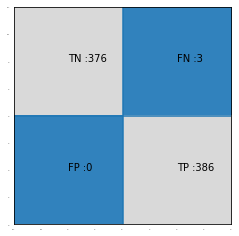

accuracy is : 0.996078431372549
F1 score is : 0.9961290322580645
Miss rate is : 0.007712082262210797
NPV is : 0.9920844327176781


Error rate : 0.00392156862745098
Sensitivity / Recall : 0.9922879177377892
Specificity : 1.0
Precision : 1.0
False positive rate : 0.0


In [30]:
#Output the classes (0 or 1) rather than the probabilities for the confusion matrix
yhat_full_test = model_single.predict_classes(X_full_test)
generate_confusion_matrix(y_full_test,yhat_full_test)

In [31]:
background = X_full_train[np.random.choice(X_full_train.shape[0], 100, replace=False)]

# explain predictions of the model on several images
e = shap.GradientExplainer(model_single, background) #Deep Explainer doesn't work yet for tf 2.0, need to use older version

In [32]:
#We look at images predicted as no plaque and plaque
shap_values = e.shap_values(X_full_test[327:333])

In [34]:
labels = y_full_test[327:333] + yhat_full_test[327:333].ravel()/10
labels

array([0. , 1.1, 0. , 0. , 1.1, 0. ])

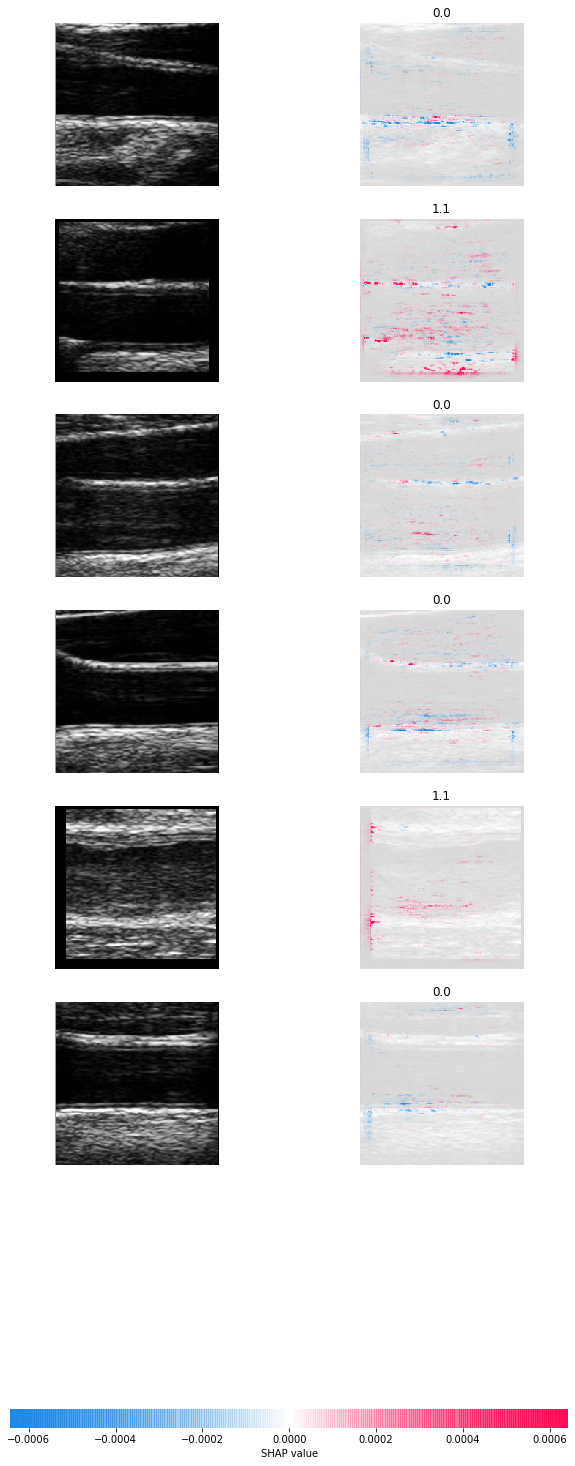

In [35]:
#Correct is first, predicted is second
shap.image_plot(shap_values, X_full_test[327:333],labels=labels[:,np.newaxis],show = False)
fig = plt.gcf()
fig.set_size_inches((10, 30))
#OVERFIT !

### Data augmentation

In [15]:
224 - 19, 224 - 19 #We will reduce images to (205,205,3)

(205, 205)

#### Create images, or load the existing augmented images in the next section

In [43]:
#Create new images from images with plaque & modify the old ones to be smaller
Full_data = []
Full_label = []

directory_file = 'CCA2_png'

counter = 0
for filename in tqdm_notebook(os.listdir(directory_file)) :
    if (filename.endswith(".png") or filename.endswith(".jpg")): 
        im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
        #Apply transformation to orginal images
        d = super_cropper(im_data,generate = 1)[0]
        Full_data.append(d.astype('float32'))
        Full_label.append(kv_dict.get(filename))
        plt.imsave('./CCA2_png_augmented/old_image{counter}_{label}.png'.format(counter = counter,
                                                                                label = kv_dict.get(filename)),d)
        counter+=1

counter = 0
generate_nb = 16
k = 5 # High number will create memory errors for the arrays, normally >10,000 images
kv_dict_filt1 = {key:value for (key,value) in kv_dict.items() if value==1} #Get a dictionary with only the images with plaque

for i in range(k):
    for filename in tqdm_notebook(kv_dict_filt1) :
        if filename.endswith(".png"): 
            im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
            
            #Apply the cropper to the loaded images
            d = super_cropper(im_data,generate = generate_nb)
            for image in d:
                Full_data.append(image.astype('float32'))
                Full_label.append(np.int64(1)) #All images created are "plaque"
                plt.imsave('./CCA2_png_augmented/new_image{counter}_1.png'.format(counter = counter),image)
                counter+=1
        else:
            continue

In [10]:
#If all files are already created, load them here
Full_data = []
Full_label = []
directory='CCA2_png_augmented'

for filename in tqdm_notebook(os.listdir(directory)) :
    if filename.endswith(".png") or filename.endswith(".jpg"):
        if filename.endswith("1.png"):
            Full_label.append(np.int64(1)) #Get the 0 or 1 indications
        else:
            Full_label.append(np.int64(0))
        im = image_load(directory, filename, sizeh = 205, sizev = 205)
        Full_data.append(im)
    else:
        continue

In [11]:
print(len(Full_data))
print(sum(Full_label))
sum(Full_label) / len(Full_data) #Share of 

9551
4860


0.5088472411265836

In [12]:
#Train Test Split
X_full_train, X_full_1, y_full_train, y_full_1 = train_test_split(np.array(Full_data), np.array(Full_label), 
                                                              test_size=0.2, random_state=42, stratify = Full_label)
#Train Test Split
X_full_cv, X_full_test, y_full_cv, y_full_test = train_test_split(X_full_1, y_full_1, 
                                                              test_size=0.4, random_state=42, stratify = y_full_1)


In [13]:
X_full_train, X_full_cv, X_full_test = format_set(X_full_train, X_full_cv, X_full_test,img_width = 205,img_height = 205)

In [21]:
nb_filters = 32
nb_pool = 2
nb_conv = 3

model_single = Sequential(name = 'Full_data_model')

#Add max pooling layers for each convolution, and then pass the results through a dense layer, and output with a sigmoid

model_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu', input_shape=X_full_train.shape[1:]))
model_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

model_single.add(Dropout(0.25)) #Avoid overfitting
model_single.add(Flatten()) # this converts the 3D feature maps to 1D feature vectors

model_single.add(Dense(128, activation='relu'))
model_single.add(Dropout(0.5)) #Avoid overfitting
model_single.add(Dense(1, activation='sigmoid'))

model_single.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_single.summary()

Model: "Full_data_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 203, 203, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 101, 101, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 99, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 32)    

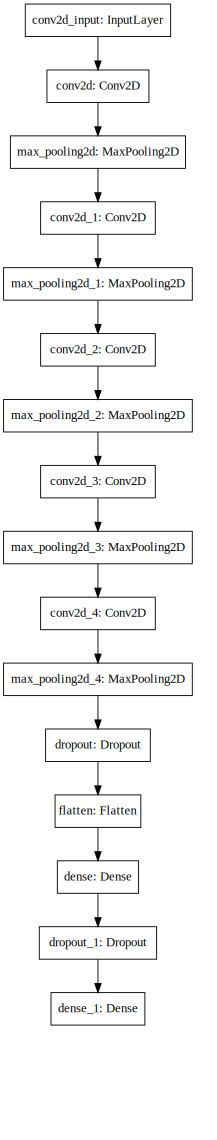

In [22]:
SVG(model_to_dot(model_single, dpi = 65,rankdir = 'TB').create(prog='dot', format='svg'))

In [23]:
model_single.fit(X_full_train, y_full_train, batch_size=128, epochs=15, verbose=1,validation_data=(X_full_cv, y_full_cv))

Train on 7640 samples, validate on 1146 samples
Epoch 1/15
7640/7640 [==============================] - ETA: 7:53 - loss: 0.7001 - accuracy: 0.45 - ETA: 5:39 - loss: 0.6963 - accuracy: 0.49 - ETA: 4:45 - loss: 0.6984 - accuracy: 0.49 - ETA: 4:15 - loss: 0.6962 - accuracy: 0.50 - ETA: 3:59 - loss: 0.6953 - accuracy: 0.50 - ETA: 3:49 - loss: 0.6950 - accuracy: 0.50 - ETA: 3:39 - loss: 0.6942 - accuracy: 0.50 - ETA: 3:33 - loss: 0.6930 - accuracy: 0.51 - ETA: 3:25 - loss: 0.6924 - accuracy: 0.52 - ETA: 3:20 - loss: 0.6923 - accuracy: 0.52 - ETA: 3:18 - loss: 0.6919 - accuracy: 0.52 - ETA: 3:12 - loss: 0.6920 - accuracy: 0.52 - ETA: 3:07 - loss: 0.6910 - accuracy: 0.52 - ETA: 3:02 - loss: 0.6901 - accuracy: 0.53 - ETA: 2:57 - loss: 0.6895 - accuracy: 0.53 - ETA: 2:53 - loss: 0.6888 - accuracy: 0.52 - ETA: 2:48 - loss: 0.6882 - accuracy: 0.53 - ETA: 2:44 - loss: 0.6883 - accuracy: 0.53 - ETA: 2:41 - loss: 0.6882 - accuracy: 0.53 - ETA: 2:37 - loss: 0.6872 - accuracy: 0.53 - ETA: 2:33 - loss

Epoch 4/15
7640/7640 [==============================] - ETA: 3:36 - loss: 0.2832 - accuracy: 0.87 - ETA: 3:42 - loss: 0.2922 - accuracy: 0.86 - ETA: 3:36 - loss: 0.3167 - accuracy: 0.86 - ETA: 3:31 - loss: 0.2887 - accuracy: 0.88 - ETA: 3:27 - loss: 0.2958 - accuracy: 0.87 - ETA: 3:20 - loss: 0.2993 - accuracy: 0.86 - ETA: 3:18 - loss: 0.2989 - accuracy: 0.86 - ETA: 3:15 - loss: 0.2952 - accuracy: 0.87 - ETA: 3:18 - loss: 0.2925 - accuracy: 0.87 - ETA: 3:13 - loss: 0.2956 - accuracy: 0.87 - ETA: 3:06 - loss: 0.2892 - accuracy: 0.87 - ETA: 3:03 - loss: 0.2877 - accuracy: 0.87 - ETA: 3:00 - loss: 0.2891 - accuracy: 0.87 - ETA: 2:57 - loss: 0.2904 - accuracy: 0.87 - ETA: 2:55 - loss: 0.2884 - accuracy: 0.87 - ETA: 2:49 - loss: 0.2911 - accuracy: 0.87 - ETA: 2:46 - loss: 0.2852 - accuracy: 0.87 - ETA: 2:42 - loss: 0.2848 - accuracy: 0.87 - ETA: 2:38 - loss: 0.2814 - accuracy: 0.88 - ETA: 2:34 - loss: 0.2805 - accuracy: 0.88 - ETA: 2:30 - loss: 0.2790 - accuracy: 0.88 - ETA: 2:28 - loss: 0.

Epoch 7/15
7640/7640 [==============================] - ETA: 2:58 - loss: 0.1462 - accuracy: 0.92 - ETA: 2:54 - loss: 0.1460 - accuracy: 0.92 - ETA: 2:50 - loss: 0.1247 - accuracy: 0.94 - ETA: 2:50 - loss: 0.1249 - accuracy: 0.94 - ETA: 2:48 - loss: 0.1350 - accuracy: 0.94 - ETA: 2:45 - loss: 0.1471 - accuracy: 0.94 - ETA: 2:42 - loss: 0.1466 - accuracy: 0.94 - ETA: 2:38 - loss: 0.1438 - accuracy: 0.94 - ETA: 2:34 - loss: 0.1462 - accuracy: 0.94 - ETA: 2:33 - loss: 0.1457 - accuracy: 0.94 - ETA: 2:31 - loss: 0.1470 - accuracy: 0.94 - ETA: 2:28 - loss: 0.1510 - accuracy: 0.94 - ETA: 2:26 - loss: 0.1468 - accuracy: 0.94 - ETA: 2:22 - loss: 0.1473 - accuracy: 0.94 - ETA: 2:19 - loss: 0.1440 - accuracy: 0.94 - ETA: 2:17 - loss: 0.1396 - accuracy: 0.94 - ETA: 2:15 - loss: 0.1430 - accuracy: 0.94 - ETA: 2:12 - loss: 0.1415 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1394 - accuracy: 0.94 - ETA: 2:05 - loss: 0.1412 - accuracy: 0.94 - ETA: 2:02 - loss: 0.1411 - accuracy: 0.94 - ETA: 1:59 - loss: 0.

Epoch 10/15
7640/7640 [==============================] - ETA: 3:35 - loss: 0.0675 - accuracy: 0.96 - ETA: 3:29 - loss: 0.0791 - accuracy: 0.96 - ETA: 3:27 - loss: 0.1023 - accuracy: 0.96 - ETA: 3:24 - loss: 0.1234 - accuracy: 0.95 - ETA: 3:19 - loss: 0.1230 - accuracy: 0.95 - ETA: 3:15 - loss: 0.1256 - accuracy: 0.95 - ETA: 3:12 - loss: 0.1198 - accuracy: 0.95 - ETA: 3:09 - loss: 0.1120 - accuracy: 0.96 - ETA: 3:05 - loss: 0.1126 - accuracy: 0.95 - ETA: 3:02 - loss: 0.1105 - accuracy: 0.96 - ETA: 2:58 - loss: 0.1124 - accuracy: 0.95 - ETA: 2:56 - loss: 0.1100 - accuracy: 0.95 - ETA: 2:54 - loss: 0.1053 - accuracy: 0.96 - ETA: 2:50 - loss: 0.1030 - accuracy: 0.96 - ETA: 2:47 - loss: 0.1074 - accuracy: 0.95 - ETA: 2:43 - loss: 0.1071 - accuracy: 0.96 - ETA: 2:40 - loss: 0.1066 - accuracy: 0.96 - ETA: 2:36 - loss: 0.1065 - accuracy: 0.96 - ETA: 2:32 - loss: 0.1066 - accuracy: 0.96 - ETA: 2:28 - loss: 0.1059 - accuracy: 0.96 - ETA: 2:25 - loss: 0.1059 - accuracy: 0.96 - ETA: 2:21 - loss: 0

Epoch 13/15
7640/7640 [==============================] - ETA: 3:31 - loss: 0.0703 - accuracy: 0.98 - ETA: 3:30 - loss: 0.0535 - accuracy: 0.98 - ETA: 3:27 - loss: 0.0543 - accuracy: 0.98 - ETA: 3:25 - loss: 0.0505 - accuracy: 0.98 - ETA: 3:21 - loss: 0.0550 - accuracy: 0.98 - ETA: 3:20 - loss: 0.0650 - accuracy: 0.97 - ETA: 3:20 - loss: 0.0603 - accuracy: 0.97 - ETA: 3:16 - loss: 0.0586 - accuracy: 0.97 - ETA: 3:12 - loss: 0.0588 - accuracy: 0.97 - ETA: 3:08 - loss: 0.0589 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0673 - accuracy: 0.97 - ETA: 3:01 - loss: 0.0655 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0657 - accuracy: 0.97 - ETA: 2:54 - loss: 0.0688 - accuracy: 0.97 - ETA: 2:50 - loss: 0.0690 - accuracy: 0.97 - ETA: 2:48 - loss: 0.0690 - accuracy: 0.97 - ETA: 2:45 - loss: 0.0667 - accuracy: 0.97 - ETA: 2:40 - loss: 0.0687 - accuracy: 0.97 - ETA: 2:36 - loss: 0.0684 - accuracy: 0.97 - ETA: 2:32 - loss: 0.0668 - accuracy: 0.97 - ETA: 2:28 - loss: 0.0678 - accuracy: 0.97 - ETA: 2:24 - loss: 0

In [26]:
test_score, test_acc = model_single.evaluate(X_full_test,y_full_test)

765/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 10s 13ms/sample - loss: 0.0436 - accuracy: 0.9712


In [27]:
print('Test accuracy is:', test_acc)
print('Test score is :', test_score)

Test accuracy is: 0.97124183
Test score is : 0.07959205131259521


In [19]:
#Output the classes (0 or 1) rather than the probabilities for the confusion matrix
yhat_full_test = model_single.predict_classes(X_full_test)
yhat_full_test_pred = model_single.predict(X_full_test) #Get the probabilities in case

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       376
           1       0.95      1.00      0.97       389

    accuracy                           0.97       765
   macro avg       0.97      0.97      0.97       765
weighted avg       0.97      0.97      0.97       765



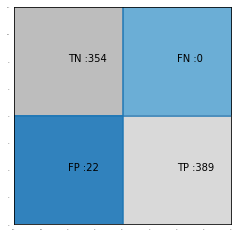

accuracy is : 0.9712418300653595
F1 score is : 0.9725
Miss rate is : 0.0
NPV is : 1.0


Error rate : 0.02875816993464052
Sensitivity / Recall : 1.0
Specificity : 0.9414893617021277
Precision : 0.9464720194647201
False positive rate : 0.05851063829787234


In [29]:
generate_confusion_matrix(y_full_test,yhat_full_test)

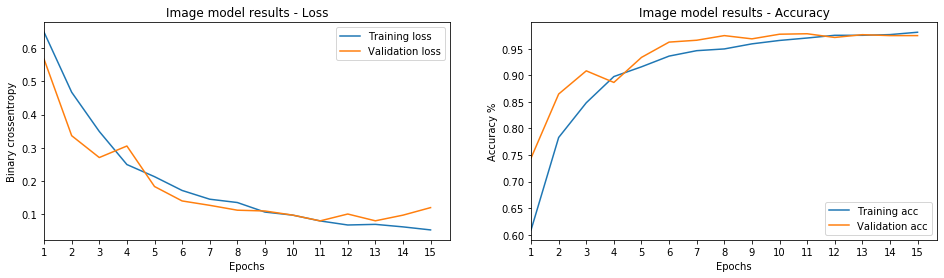

In [30]:
model_graphs(model_single,labels = False)

In [14]:
# model_single.save('./Models/model_single.h5')
model_single = tf.keras.models.load_model('./Models/model_single.h5')

## SHAP

SHAP (SHapley Additive exPlanations) (https://github.com/slundberg/shap) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations.


In [17]:
background = X_full_train[np.random.choice(X_full_train.shape[0], 250, replace=False)]

# explain predictions of the model on several images
e = shap.GradientExplainer(model_single, background) #Deep Explainer doesn't work yet for tf 2.0, need to use older version
# e = shap.DeepExplainer(model_single, background) #Deep Explainer doesn't work yet for tf 2.0, need to use older version


In [20]:
B = np.block([yhat_full_test,y_full_test[:,np.newaxis]])
np.where(np.sum(B,axis=1) == 1 )[0] #Get misclassifications

array([  1,   2,  36,  44, 230, 233, 245, 251, 327, 332, 408, 428, 472,
       511, 536, 580, 606, 607, 617, 631, 643, 716], dtype=int64)

In [21]:
print(yhat_full_test[245:252].ravel())
print(y_full_test[245:252])

[1 0 0 1 1 1 1]
[0 0 0 1 1 1 0]


In [22]:
#We look at images predicted as no plaque and plaque
shap_values = e.shap_values(X_full_test[245:247])

In [23]:
labels = y_full_test[245:247] + yhat_full_test[245:247].ravel()/10
labels

array([0.1, 0. ])

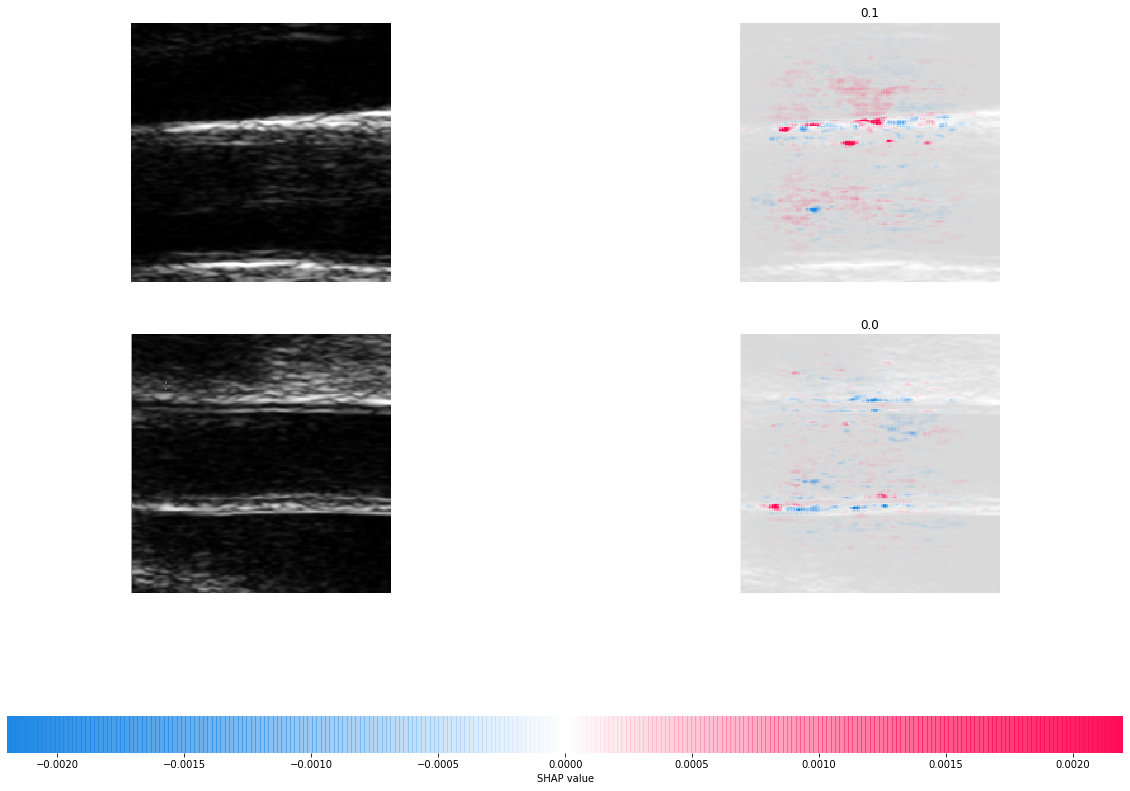

In [24]:
#Correct is first, predicted is second
shap.image_plot(shap_values, X_full_test[245:247],labels = labels[:,np.newaxis],show = False)
fig = plt.gcf()
fig.set_size_inches((20, 15))
plt.savefig('model_single_shap.jpg')

### Combined labels and images

#### Create images, or load the existing augmented images in the next section

In [235]:
#Create new images from images with plaque & modify the old ones to be smaller
#Also modify the old labels and create new labels

Full_data_org = []
Full_label_org = []
Full_data_tag = []

directory_file = 'CCA2_png'
directory_label = 'CCA2_2labels'

counter = 0
for filename in tqdm_notebook(os.listdir(directory_file)) :
    if '_data_CCA2_'+filename in kv_tag_dict and (filename.endswith(".png") or filename.endswith(".jpg")): 
        im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
        im_label = image_load(directory_label, '_data_CCA2_'+filename, sizeh = 224, sizev = 224)
        
        #Apply the cropper to the loaded images
        d,l = super_cropper([im_data,im_label],generate = 1,use_list = True)
        Full_data_org.append(d[0].astype('float32'))
        Full_label_org.append(kv_dict.get(filename)) #Get the 0 or 1 indications from one of the dictionaries
        plt.imsave('./CCA2_2_augmented/old_image{counter}_{label}.png'.format(counter = counter,
                                                                              label = kv_dict.get(filename)),d[0])
        #Save the label images as well, though the class is the same, so no need to add it twice
        Full_data_tag.append(l[0].astype('float32'))
        plt.imsave('./CCA2_2_labels_augmented/old_image{counter}_{label}.png'.format(counter = counter,
                                                                                     label = kv_dict.get(filename)),l[0])
        counter+=1
    else:
        continue

counter = 0
generate_nb = 16
k = 5 # High number will create memory errors for the arrays, normally >10,000 images
kv_dict_filt1 = {key:value for (key,value) in kv_dict.items() if value==1}

for i in range(k):
    for filename in tqdm_notebook(kv_dict_filt1) :
        if '_data_CCA2_'+filename in kv_tag_dict and filename.endswith(".png"): #Cross check that these are in the labels
            im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
            im_label = image_load(directory_label, '_data_CCA2_'+filename, sizeh = 224, sizev = 224)
            
            #Apply the cropper to the loaded images
            d,l = super_cropper([im_data,im_label],generate = generate_nb,use_list = True)
            for image,label in zip(d,l):
                Full_data_org.append(image.astype('float32'))
                Full_label_org.append(np.int64(1)) #All images created are "plaque"
                plt.imsave('./CCA2_2_augmented/new_image{counter}_1.png'.format(counter = counter),image)
                
                Full_data_tag.append(label.astype('float32'))
                plt.imsave('./CCA2_2_labels_augmented/new_image{counter}_1.png'.format(counter = counter),label)
                counter+=1
        else:
            continue

In [10]:
#If data already exists, load from here

Full_data_org = []
Full_label_org = []
Full_data_tag = []

directory_file = 'CCA2_2_augmented'
directory_label = 'CCA2_2_labels_augmented'

for filename in tqdm_notebook(os.listdir(directory_file)) :
    if filename.endswith(".png") or filename.endswith(".jpg"):
        if filename.endswith("1.png"):
            Full_label_org.append(np.int64(1)) #Get the 0 or 1 indications
        else:
            Full_label_org.append(np.int64(0))
        im = image_load(directory_file, filename, sizeh = 205, sizev = 205)
        Full_data_org.append(im)
    else:
        continue

for filename in tqdm_notebook(os.listdir(directory_label)) :
    if filename.endswith(".png") or filename.endswith(".jpg"):
        im = image_load(directory_label, filename, sizeh = 205, sizev = 205)
        Full_data_tag.append(im)
    else:
        continue

In [11]:
#Train Test Split
X_train_org, X_org_1, y_train, y_1, X_train_tag, X_tag_1 = train_test_split(
                    np.array(Full_data_org), np.array(Full_label_org), np.array(Full_data_tag), 
                    test_size=0.2, random_state=42, stratify = Full_label_org)

#Train Test Split for validation set
X_cv_org, X_test_org, y_cv, y_test, X_cv_tag, X_test_tag = train_test_split(
                    X_org_1, y_1, X_tag_1,
                    test_size=0.4, random_state=42, stratify = y_1)


In [12]:
X_train_org, X_cv_org, X_test_org = format_set(X_train_org, X_cv_org, X_test_org,img_width = 205,img_height=205)
X_train_tag, X_cv_tag, X_test_tag = format_set(X_train_tag, X_cv_tag, X_test_tag,img_width = 205,img_height=205)

In [22]:
nb_filters = 32
nb_pool = 2
nb_conv = 3

inputs = [X_train_org,X_train_tag]

#BatchNormlization layers cause the model to seriously overfit
original_input = Input(shape=inputs[0].shape[1:])
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation = 'relu')(original_input)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Dropout(0.25)(x_org)

tagged_input = Input(shape=inputs[1].shape[1:])
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation = 'relu')(tagged_input)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Dropout(0.25)(x_tag)

x = Concatenate()([x_org,x_tag])
x = Flatten()(x) # this converts the 3D feature maps to 1D feature vectors

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) #Avoid overfitting
main_output = Dense(1, activation='sigmoid')(x)

model_combo = Model(inputs=[original_input, tagged_input], outputs=[main_output])
model_combo.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_combo.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 205, 205, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 205, 205, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 203, 203, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 203, 203, 32) 896         input_2[0][0]                    
______________________________________________________________________________________________

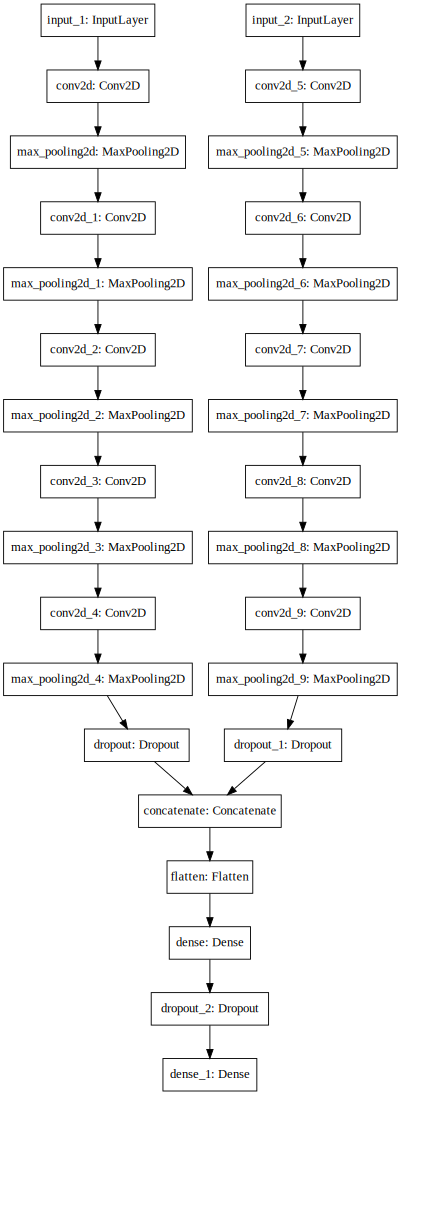

In [23]:
SVG(model_to_dot(model_combo, dpi = 65).create(prog='dot', format='svg'))

In [24]:
model_combo.fit([X_train_org,X_train_tag], y_train, batch_size=128, epochs=15, verbose=1,
           validation_data=([X_cv_org,X_cv_tag], y_cv))

Train on 7496 samples, validate on 1125 samples
Epoch 1/15
7496/7496 [==============================] - ETA: 13:57 - loss: 0.6947 - accuracy: 0.476 - ETA: 9:31 - loss: 0.6974 - accuracy: 0.480 - ETA: 7:40 - loss: 0.6947 - accuracy: 0.48 - ETA: 6:37 - loss: 0.6941 - accuracy: 0.49 - ETA: 5:56 - loss: 0.6926 - accuracy: 0.51 - ETA: 5:27 - loss: 0.6903 - accuracy: 0.52 - ETA: 5:04 - loss: 0.6875 - accuracy: 0.53 - ETA: 4:50 - loss: 0.6870 - accuracy: 0.53 - ETA: 4:34 - loss: 0.6829 - accuracy: 0.54 - ETA: 4:21 - loss: 0.6814 - accuracy: 0.54 - ETA: 4:11 - loss: 0.6772 - accuracy: 0.55 - ETA: 4:03 - loss: 0.6744 - accuracy: 0.56 - ETA: 3:55 - loss: 0.6722 - accuracy: 0.57 - ETA: 3:48 - loss: 0.6691 - accuracy: 0.57 - ETA: 3:39 - loss: 0.6638 - accuracy: 0.58 - ETA: 3:32 - loss: 0.6551 - accuracy: 0.60 - ETA: 3:25 - loss: 0.6469 - accuracy: 0.61 - ETA: 3:18 - loss: 0.6377 - accuracy: 0.62 - ETA: 3:11 - loss: 0.6286 - accuracy: 0.63 - ETA: 3:05 - loss: 0.6168 - accuracy: 0.64 - ETA: 2:59 - l

7496/7496 [==============================] - ETA: 4:03 - loss: 0.0839 - accuracy: 0.97 - ETA: 3:53 - loss: 0.0971 - accuracy: 0.95 - ETA: 3:51 - loss: 0.0838 - accuracy: 0.96 - ETA: 3:47 - loss: 0.0859 - accuracy: 0.96 - ETA: 3:43 - loss: 0.0874 - accuracy: 0.96 - ETA: 3:38 - loss: 0.0824 - accuracy: 0.96 - ETA: 3:33 - loss: 0.0791 - accuracy: 0.96 - ETA: 3:28 - loss: 0.0742 - accuracy: 0.97 - ETA: 3:22 - loss: 0.0709 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0747 - accuracy: 0.97 - ETA: 3:13 - loss: 0.0732 - accuracy: 0.97 - ETA: 3:09 - loss: 0.0720 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0750 - accuracy: 0.97 - ETA: 3:00 - loss: 0.0758 - accuracy: 0.97 - ETA: 2:56 - loss: 0.0797 - accuracy: 0.97 - ETA: 2:51 - loss: 0.0787 - accuracy: 0.97 - ETA: 2:47 - loss: 0.0812 - accuracy: 0.97 - ETA: 2:43 - loss: 0.0808 - accuracy: 0.97 - ETA: 2:39 - loss: 0.0799 - accuracy: 0.97 - ETA: 2:35 - loss: 0.0789 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0779 - accuracy: 0.97 - ETA: 2:27 - loss: 0.0778 - accu

7496/7496 [==============================] - ETA: 3:59 - loss: 0.0207 - accuracy: 1.00 - ETA: 3:46 - loss: 0.0511 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0458 - accuracy: 0.98 - ETA: 3:32 - loss: 0.0371 - accuracy: 0.99 - ETA: 3:27 - loss: 0.0316 - accuracy: 0.99 - ETA: 3:21 - loss: 0.0270 - accuracy: 0.99 - ETA: 3:17 - loss: 0.0275 - accuracy: 0.99 - ETA: 3:12 - loss: 0.0267 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0317 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0307 - accuracy: 0.99 - ETA: 3:00 - loss: 0.0293 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0293 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0352 - accuracy: 0.99 - ETA: 2:48 - loss: 0.0370 - accuracy: 0.98 - ETA: 2:44 - loss: 0.0371 - accuracy: 0.98 - ETA: 2:41 - loss: 0.0385 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0381 - accuracy: 0.98 - ETA: 2:34 - loss: 0.0377 - accuracy: 0.98 - ETA: 2:30 - loss: 0.0390 - accuracy: 0.98 - ETA: 2:26 - loss: 0.0391 - accuracy: 0.98 - ETA: 2:23 - loss: 0.0379 - accuracy: 0.98 - ETA: 2:19 - loss: 0.0369 - accu

In [25]:
test_score2, test_acc2 = model_combo.evaluate([X_test_org,X_test_tag],y_test)

750/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 13s 17ms/sample - loss: 0.0398 - accuracy: 0.9813


In [26]:
print('Test accuracy is:', test_acc2)
print('Test score is :', test_score2)

Test accuracy is: 0.9813333
Test score is : 0.07463928801938892


In [16]:
yhat_test_pred = model_combo.predict([X_test_org,X_test_tag]) #predict_classes doesn't work for non sequential, returns % chance
yhat_test = np.around(yhat_test_pred).flatten().astype(int) #Round to 0 or 1 depending on prediction

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       374
           1       0.96      1.00      0.98       376

    accuracy                           0.98       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.98      0.98      0.98       750



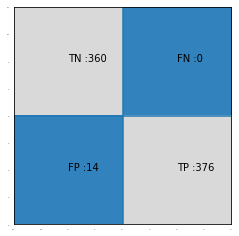

accuracy is : 0.9813333333333333
F1 score is : 0.9817232375979112
Miss rate is : 0.0
NPV is : 1.0


Error rate : 0.018666666666666668
Sensitivity / Recall : 1.0
Specificity : 0.9625668449197861
Precision : 0.9641025641025641
False positive rate : 0.0374331550802139


In [28]:
generate_confusion_matrix(y_test,yhat_test)

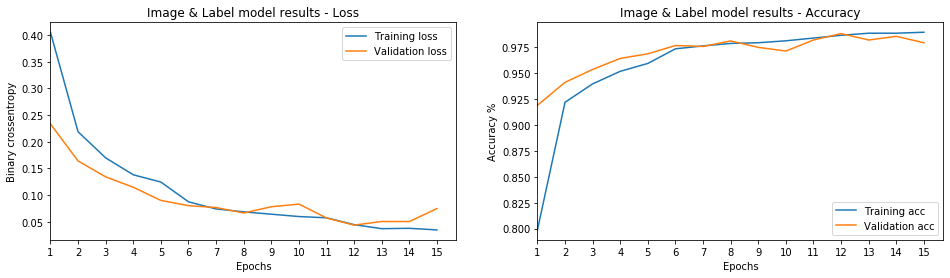

In [29]:
model_graphs(model_combo)

In [13]:
# model_combo.save('./Models/model_combo.h5')
model_combo = tf.keras.models.load_model('./Models/model_combo.h5')

In [17]:
randomizer = np.random.choice(X_train_tag.shape[0], 200, replace=False)
background = [X_train_org[randomizer],X_train_tag[randomizer]]

# # explain predictions of the model on several images
e = shap.GradientExplainer(model_combo, background) #Deep Explainer doesn't work yet for tf 2.0

In [18]:
B = np.block([yhat_test[:,np.newaxis],y_test[:,np.newaxis]])
np.where(np.sum(B,axis=1) == 1 )[0] #Get misclassifications

array([105, 106, 117, 137, 233, 240, 322, 415, 422, 449, 458, 552, 579,
       638], dtype=int64)

In [19]:
print(yhat_test[103:109],yhat_test[np.where(np.sum(B,axis=1) == 1 )[0]])
print(y_test[103:109],y_test[np.where(np.sum(B,axis=1) == 1 )[0]])

[0 0 1 1 1 1] [1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 1 1] [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [20]:
#We look at images predicted as no plaque and plaque
shap_values = e.shap_values([X_test_org[103:109],X_test_tag[103:109]])
labels_org = y_test[103:109] + yhat_test[103:109]/10
labels_org

array([0. , 0. , 0.1, 0.1, 1.1, 1.1])

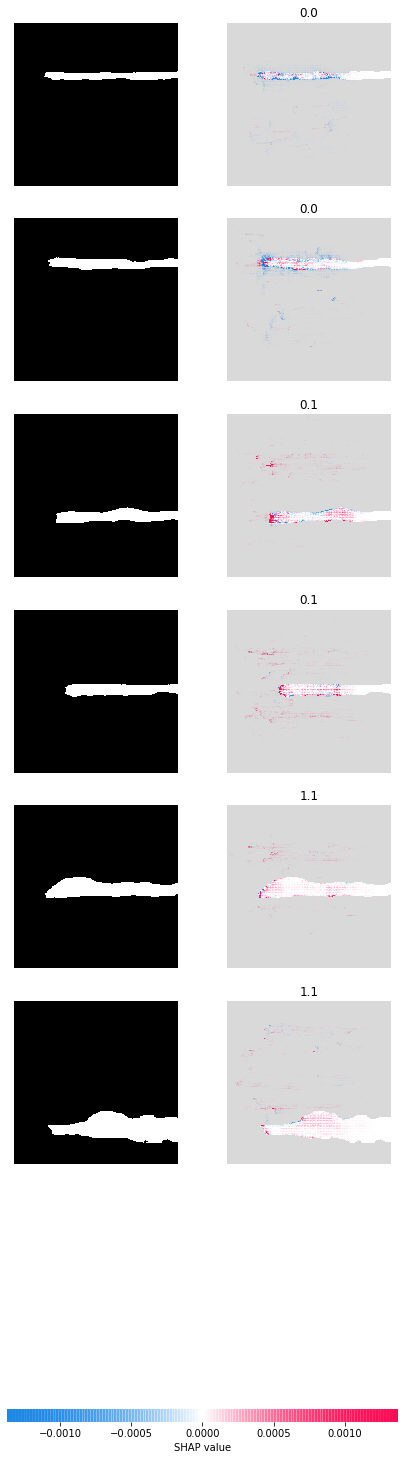

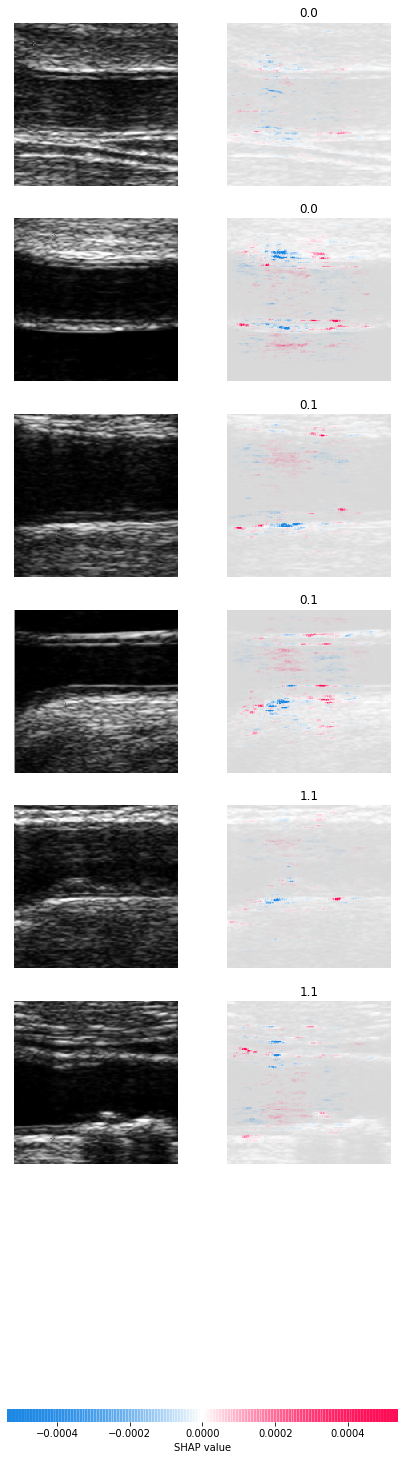

In [25]:
#Get one explanation for each input (in this case 2), and a len of 1 on shap values for 1 output
shap.image_plot([shap_values[0][1]], X_test_tag[103:109],labels = labels_org[:,np.newaxis],show=False) #Tag
fig = plt.gcf()
fig.set_size_inches((7, 30),forward = True)

shap.image_plot([shap_values[0][0]], X_test_org[103:109],labels = labels_org[:,np.newaxis],show = False) #Orginals
fig = plt.gcf()
fig.set_size_inches((7, 30))

### Converting data to greyscale for faster run

#### If exist already, load from code underneath

In [36]:
#Create new images from images with plaque & modify the old ones to be smaller
Full_data_gray = []
Full_label_gray = []

directory_file = 'CCA2_png'

counter = 0
for filename in tqdm_notebook(os.listdir(directory_file)) :
    if (filename.endswith(".png") or filename.endswith(".jpg")): 
        im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224,grayscale=True) #GRAYSCALE
        #Apply transformation to orginal images
        d = super_cropper(im_data,generate = 1,grayscale = True)[0] #GRAYSCALE
#         d = grey(im)
        Full_data_gray.append(d.astype('float32'))
        Full_label_gray.append(kv_dict.get(filename))
        plt.imsave('./Grey_images_CCA2/Grey_augmented/old_image{counter}_{label}.png'.format(counter = counter,
                                                                                label = kv_dict.get(filename)),d)
        counter+=1

counter = 0
generate_nb = 16
k = 5 # High number will create memory errors for the arrays, normally >10,000 images
kv_dict_filt1 = {key:value for (key,value) in kv_dict.items() if value==1} #Get a dictionary with only the images with plaque

for i in range(k):
    for filename in tqdm_notebook(kv_dict_filt1) :
        if filename.endswith(".png"):
            im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224,grayscale=True) #GRAYSCALE
            
            #Apply the cropper to the loaded images
            d = super_cropper(im_data,generate = generate_nb, grayscale = True) #GRAYSCALE
            for image in d:
#                 image = grey(image)
                Full_data_gray.append(image.astype('float32'))
                Full_label_gray.append(np.int64(1)) #All images created are "plaque"
                plt.imsave('./Grey_images_CCA2/Grey_augmented/new_image{counter}_1.png'.format(counter = counter),image)
                counter+=1
        else:
            continue

In [47]:
#If all files are already created, load them here
Full_data_gray = []
Full_label_gray = []
directory='Grey_images_CCA2/Grey_augmented'

for filename in tqdm_notebook(os.listdir(directory)) :
    if filename.endswith(".png") or filename.endswith(".jpg"):
        if filename.endswith("1.png"):
            Full_label_gray.append(np.int64(1)) #Get the 0 or 1 indications
        else:
            Full_label_gray.append(np.int64(0))
        im = image_load(directory, filename, sizeh = 205, sizev = 205,grayscale = True)
#         im = grey(im)
        Full_data_gray.append(im)
    else:
        continue

In [48]:
print(len(Full_data_gray))
print(sum(Full_label_gray))
sum(Full_label_gray) / len(Full_data_gray) #Share of plaque images

9551
4860


0.5088472411265836

In [49]:
#Train Test Split
X_full_train, X_full_1, y_full_train, y_full_1 = train_test_split(np.array(Full_data_gray), np.array(Full_label_gray), 
                                                              test_size=0.2, random_state=42, stratify = Full_label_gray)
#Train Test Split
X_full_cv, X_full_test, y_full_cv, y_full_test = train_test_split(X_full_1, y_full_1, 
                                                              test_size=0.4, random_state=42, stratify = y_full_1)


In [50]:
X_full_train, X_full_cv, X_full_test = format_set(X_full_train, X_full_cv, X_full_test,img_width = 205,img_height = 205, grayscale = True)

In [51]:
nb_filters = 32
nb_pool = 2
nb_conv = 3

model_single_grey = Sequential(name = 'Full_data_model')

#Add max pooling layers for each convolution, and then pass the results through a dense layer, and output with a sigmoid

model_single_grey.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu', input_shape=X_full_train.shape[1:]))
model_single_grey.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_single_grey.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_single_grey.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_single_grey.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_single_grey.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_single_grey.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_single_grey.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_single_grey.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_single_grey.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

model_single_grey.add(Dropout(0.25)) #Avoid overfitting
model_single_grey.add(Flatten()) # this converts the 3D feature maps to 1D feature vectors

model_single_grey.add(Dense(128, activation='relu'))
model_single_grey.add(Dropout(0.5)) #Avoid overfitting
model_single_grey.add(Dense(1, activation='sigmoid'))

model_single_grey.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_single_grey.summary()

Model: "Full_data_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 203, 203, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 101, 101, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 99, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 32)    

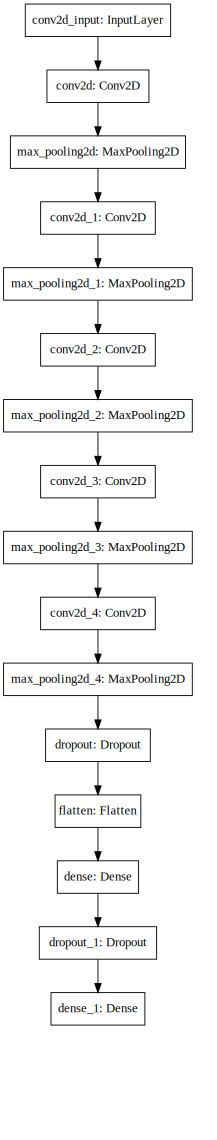

In [52]:
SVG(model_to_dot(model_single_grey, dpi = 65,rankdir = 'TB').create(prog='dot', format='svg'))

In [54]:
model_single_grey.fit(X_full_train, y_full_train, batch_size=128, epochs=15, verbose=1,validation_data=(X_full_cv, y_full_cv))

Train on 7640 samples, validate on 1146 samples
Epoch 1/15
7640/7640 [==============================] - ETA: 7:50 - loss: 0.6919 - accuracy: 0.57 - ETA: 5:43 - loss: 0.6921 - accuracy: 0.54 - ETA: 4:59 - loss: 0.6913 - accuracy: 0.53 - ETA: 4:39 - loss: 0.6923 - accuracy: 0.52 - ETA: 4:23 - loss: 0.6944 - accuracy: 0.50 - ETA: 4:11 - loss: 0.6942 - accuracy: 0.50 - ETA: 4:01 - loss: 0.6933 - accuracy: 0.51 - ETA: 3:54 - loss: 0.6931 - accuracy: 0.50 - ETA: 3:46 - loss: 0.6930 - accuracy: 0.50 - ETA: 3:39 - loss: 0.6932 - accuracy: 0.51 - ETA: 3:32 - loss: 0.6928 - accuracy: 0.51 - ETA: 3:27 - loss: 0.6928 - accuracy: 0.51 - ETA: 3:21 - loss: 0.6927 - accuracy: 0.51 - ETA: 3:15 - loss: 0.6924 - accuracy: 0.51 - ETA: 3:09 - loss: 0.6925 - accuracy: 0.51 - ETA: 3:05 - loss: 0.6922 - accuracy: 0.51 - ETA: 3:00 - loss: 0.6919 - accuracy: 0.52 - ETA: 2:56 - loss: 0.6916 - accuracy: 0.52 - ETA: 2:52 - loss: 0.6918 - accuracy: 0.51 - ETA: 2:48 - loss: 0.6913 - accuracy: 0.52 - ETA: 2:44 - loss

Epoch 4/15
7640/7640 [==============================] - ETA: 4:06 - loss: 0.3362 - accuracy: 0.83 - ETA: 3:52 - loss: 0.3893 - accuracy: 0.83 - ETA: 3:47 - loss: 0.3939 - accuracy: 0.83 - ETA: 3:40 - loss: 0.3790 - accuracy: 0.84 - ETA: 3:35 - loss: 0.3753 - accuracy: 0.85 - ETA: 3:30 - loss: 0.3806 - accuracy: 0.84 - ETA: 3:28 - loss: 0.3687 - accuracy: 0.84 - ETA: 3:26 - loss: 0.3689 - accuracy: 0.83 - ETA: 3:21 - loss: 0.3732 - accuracy: 0.83 - ETA: 3:17 - loss: 0.3727 - accuracy: 0.83 - ETA: 3:19 - loss: 0.3761 - accuracy: 0.83 - ETA: 3:16 - loss: 0.3757 - accuracy: 0.83 - ETA: 3:11 - loss: 0.3705 - accuracy: 0.84 - ETA: 3:07 - loss: 0.3697 - accuracy: 0.84 - ETA: 3:02 - loss: 0.3684 - accuracy: 0.84 - ETA: 2:57 - loss: 0.3650 - accuracy: 0.84 - ETA: 2:53 - loss: 0.3650 - accuracy: 0.84 - ETA: 2:48 - loss: 0.3632 - accuracy: 0.84 - ETA: 2:44 - loss: 0.3594 - accuracy: 0.85 - ETA: 2:39 - loss: 0.3582 - accuracy: 0.85 - ETA: 2:35 - loss: 0.3570 - accuracy: 0.85 - ETA: 2:30 - loss: 0.

Epoch 7/15
7640/7640 [==============================] - ETA: 4:14 - loss: 0.1935 - accuracy: 0.92 - ETA: 4:11 - loss: 0.1834 - accuracy: 0.92 - ETA: 4:02 - loss: 0.1984 - accuracy: 0.91 - ETA: 3:58 - loss: 0.1990 - accuracy: 0.91 - ETA: 3:50 - loss: 0.2076 - accuracy: 0.91 - ETA: 3:45 - loss: 0.1965 - accuracy: 0.92 - ETA: 3:40 - loss: 0.1878 - accuracy: 0.92 - ETA: 3:36 - loss: 0.1874 - accuracy: 0.92 - ETA: 3:33 - loss: 0.1846 - accuracy: 0.92 - ETA: 3:28 - loss: 0.1924 - accuracy: 0.92 - ETA: 3:24 - loss: 0.1918 - accuracy: 0.92 - ETA: 3:19 - loss: 0.1880 - accuracy: 0.92 - ETA: 3:14 - loss: 0.1904 - accuracy: 0.92 - ETA: 3:09 - loss: 0.1875 - accuracy: 0.92 - ETA: 3:04 - loss: 0.1884 - accuracy: 0.92 - ETA: 2:59 - loss: 0.1940 - accuracy: 0.92 - ETA: 2:55 - loss: 0.1931 - accuracy: 0.92 - ETA: 2:51 - loss: 0.1887 - accuracy: 0.92 - ETA: 2:48 - loss: 0.1879 - accuracy: 0.92 - ETA: 2:44 - loss: 0.1886 - accuracy: 0.92 - ETA: 2:39 - loss: 0.1875 - accuracy: 0.92 - ETA: 2:35 - loss: 0.

Epoch 10/15
7640/7640 [==============================] - ETA: 5:40 - loss: 0.1462 - accuracy: 0.95 - ETA: 5:32 - loss: 0.1545 - accuracy: 0.94 - ETA: 5:28 - loss: 0.1321 - accuracy: 0.95 - ETA: 5:19 - loss: 0.1373 - accuracy: 0.95 - ETA: 5:07 - loss: 0.1277 - accuracy: 0.95 - ETA: 5:04 - loss: 0.1274 - accuracy: 0.95 - ETA: 4:56 - loss: 0.1274 - accuracy: 0.95 - ETA: 4:48 - loss: 0.1252 - accuracy: 0.95 - ETA: 4:44 - loss: 0.1201 - accuracy: 0.96 - ETA: 4:38 - loss: 0.1274 - accuracy: 0.95 - ETA: 4:30 - loss: 0.1252 - accuracy: 0.95 - ETA: 4:23 - loss: 0.1328 - accuracy: 0.95 - ETA: 4:16 - loss: 0.1325 - accuracy: 0.95 - ETA: 4:10 - loss: 0.1313 - accuracy: 0.95 - ETA: 4:04 - loss: 0.1298 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1268 - accuracy: 0.95 - ETA: 3:51 - loss: 0.1253 - accuracy: 0.95 - ETA: 3:45 - loss: 0.1297 - accuracy: 0.95 - ETA: 3:40 - loss: 0.1284 - accuracy: 0.95 - ETA: 3:33 - loss: 0.1274 - accuracy: 0.95 - ETA: 3:28 - loss: 0.1277 - accuracy: 0.95 - ETA: 3:22 - loss: 0

Epoch 13/15
7640/7640 [==============================] - ETA: 4:41 - loss: 0.1650 - accuracy: 0.95 - ETA: 4:13 - loss: 0.1174 - accuracy: 0.96 - ETA: 4:12 - loss: 0.1183 - accuracy: 0.95 - ETA: 4:00 - loss: 0.1069 - accuracy: 0.96 - ETA: 3:51 - loss: 0.1063 - accuracy: 0.95 - ETA: 3:48 - loss: 0.1011 - accuracy: 0.96 - ETA: 3:45 - loss: 0.1134 - accuracy: 0.95 - ETA: 3:39 - loss: 0.1072 - accuracy: 0.96 - ETA: 3:37 - loss: 0.1112 - accuracy: 0.95 - ETA: 3:32 - loss: 0.1034 - accuracy: 0.96 - ETA: 3:27 - loss: 0.1039 - accuracy: 0.96 - ETA: 3:22 - loss: 0.1045 - accuracy: 0.96 - ETA: 3:22 - loss: 0.1005 - accuracy: 0.96 - ETA: 3:27 - loss: 0.0991 - accuracy: 0.96 - ETA: 3:24 - loss: 0.0998 - accuracy: 0.96 - ETA: 3:23 - loss: 0.0991 - accuracy: 0.96 - ETA: 3:22 - loss: 0.1014 - accuracy: 0.96 - ETA: 3:19 - loss: 0.1005 - accuracy: 0.96 - ETA: 3:15 - loss: 0.0998 - accuracy: 0.96 - ETA: 3:12 - loss: 0.0981 - accuracy: 0.96 - ETA: 3:09 - loss: 0.1016 - accuracy: 0.96 - ETA: 3:05 - loss: 0

In [55]:
test_score_grey, test_acc_grey = model_single_grey.evaluate(X_full_test,y_full_test)

765/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 12s 16ms/sample - loss: 0.0330 - accuracy: 0.9817


In [57]:
print('Test accuracy is:', test_acc_grey)
print('Test score is :', test_score_grey)

Test accuracy is: 0.98169935
Test score is : 0.05620368022982981


In [58]:
#Output the classes (0 or 1) rather than the probabilities for the confusion matrix
yhat_full_test = model_single_grey.predict_classes(X_full_test)
yhat_full_test_pred = model_single_grey.predict(X_full_test) #Get the probabilities in case

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       376
           1       0.97      1.00      0.98       389

    accuracy                           0.98       765
   macro avg       0.98      0.98      0.98       765
weighted avg       0.98      0.98      0.98       765



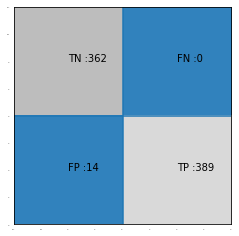

accuracy is : 0.9816993464052287
F1 score is : 0.9823232323232324
Miss rate is : 0.0
NPV is : 1.0


Error rate : 0.018300653594771243
Sensitivity / Recall : 1.0
Specificity : 0.9627659574468085
Precision : 0.9652605459057072
False positive rate : 0.03723404255319149


In [60]:
generate_confusion_matrix(y_full_test,yhat_full_test)

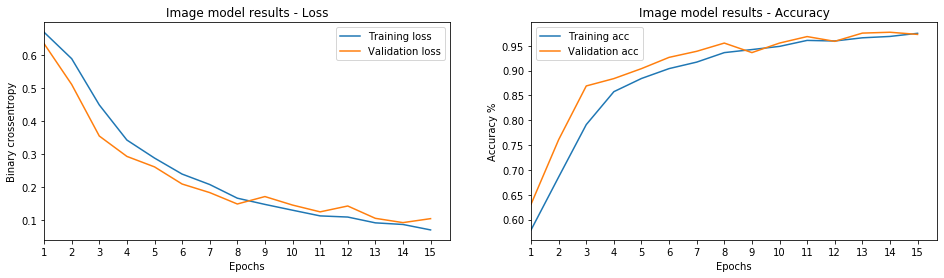

In [61]:
model_graphs(model_single_grey,labels = False)

In [75]:
background = X_full_train[np.random.choice(X_full_train.shape[0], 100, replace=False)]

# # explain predictions of the model on several images
e = shap.GradientExplainer(model_single_grey, background) #Deep Explainer doesn't work yet for tf 2.0
B = np.block([yhat_full_test,y_full_test[:,np.newaxis]])
print(np.where(np.sum(B,axis=1) == 1 )[0]) #Get misclassifications


[  2  55 233 245 264 327 332 484 493 511 637 645 695 728]


In [77]:
B

array([[0, 0],
       [0, 0],
       [1, 0],
       ...,
       [1, 1],
       [0, 0],
       [0, 0]], dtype=int64)

In [76]:
labels_org_grey = y_full_test[327:333] + yhat_full_test[327:333].ravel()/10
labels_org_grey

array([0.1, 1.1, 0. , 0. , 1.1, 0.1])

In [78]:
#We look at images predicted as no plaque and plaque
shap_values = e.shap_values(X_full_test[327:333])

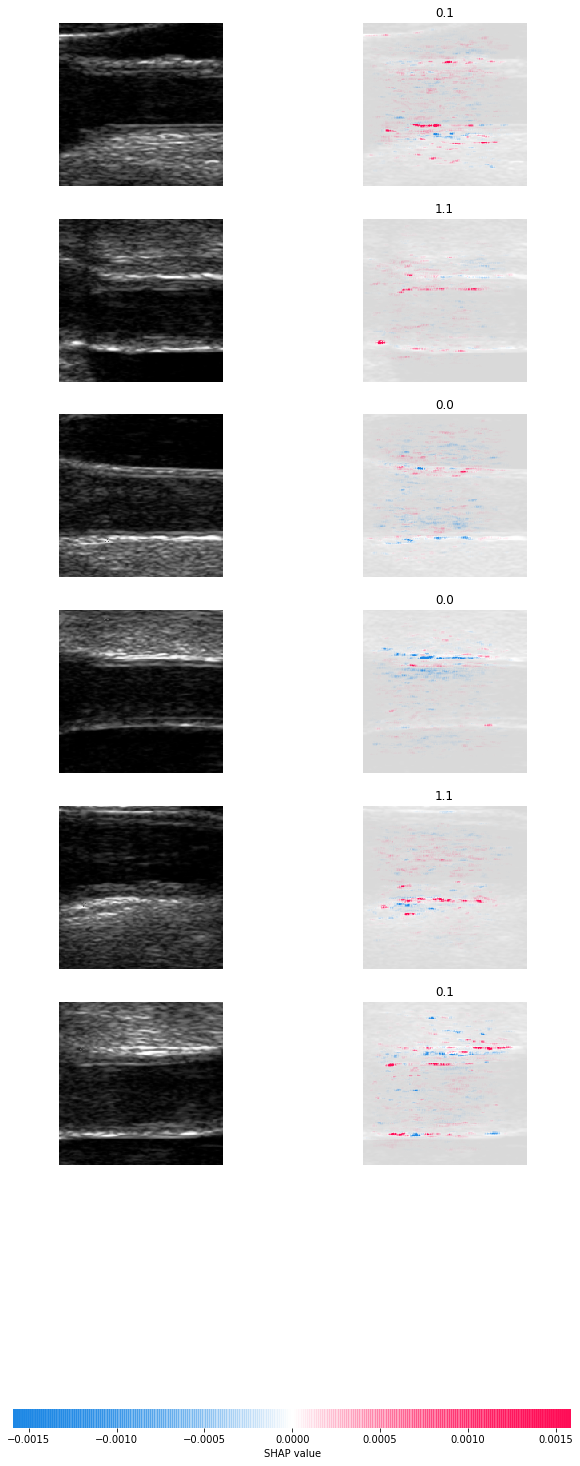

In [79]:
#Get one explanation for each input (in this case 2), and a len of 1 on shap values for 1 output
shap.image_plot(shap_values, X_full_test[327:333],labels = labels_org_grey[:,np.newaxis],show = False) #Tag
fig = plt.gcf()
fig.set_size_inches((10, 30))


In [82]:
#Create new images from images with plaque & modify the old ones to be smaller
#Also modify the old labels and create new labels

Full_data_org_grey = []
Full_label_org_grey = []
Full_data_tag_grey = []

directory_file = 'CCA2_png'
directory_label = 'CCA2_2labels'

counter = 0
for filename in tqdm_notebook(os.listdir(directory_file)) :
    if '_data_CCA2_'+filename in kv_tag_dict and (filename.endswith(".png") or filename.endswith(".jpg")): 
        im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224,grayscale = True) #GRAYSCALE
        im_label = image_load(directory_label, '_data_CCA2_'+filename, sizeh = 224, sizev = 224,grayscale = True) #GRAYSCALE
        
        #Apply the cropper to the loaded images
        d,l = super_cropper([im_data,im_label],generate = 1,use_list = True,grayscale = True) #GRAYSCALE
        Full_data_org_grey.append(d[0].astype('float32'))
        Full_label_org_grey.append(kv_dict.get(filename)) #Get the 0 or 1 indications from one of the dictionaries
        plt.imsave('./Grey_images_CCA2/Grey_2_augmented/old_image{counter}_{label}.png'.format(counter = counter,
                                                                              label = kv_dict.get(filename)),d[0])
        #Save the label images as well, though the class is the same, so no need to add it twice
        Full_data_tag_grey.append(l[0].astype('float32'))
        plt.imsave('./Grey_images_CCA2/Grey_2_labels/old_image{counter}_{label}.png'.format(counter = counter,
                                                                                     label = kv_dict.get(filename)),l[0])
        counter+=1
    else:
        continue

counter = 0
generate_nb = 16
k = 5 # High number will create memory errors for the arrays, normally >10,000 images
kv_dict_filt1 = {key:value for (key,value) in kv_dict.items() if value==1}

for i in range(k):
    for filename in tqdm_notebook(kv_dict_filt1) :
        if '_data_CCA2_'+filename in kv_tag_dict and filename.endswith(".png"): #Cross check that these are in the labels
            im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224, grayscale = True) #GRAYSCALE
            im_label = image_load(directory_label, '_data_CCA2_'+filename, sizeh = 224, sizev = 224, grayscale = True) #GRAYSCALE
            
            #Apply the cropper to the loaded images
            d,l = super_cropper([im_data,im_label],generate = generate_nb,use_list = True, grayscale = True) #GRAYSCALE
            for image,label in zip(d,l):
                Full_data_org_grey.append(image.astype('float32'))
                Full_label_org_grey.append(np.int64(1)) #All images created are "plaque"
                plt.imsave('./Grey_images_CCA2/Grey_2_augmented/new_image{counter}_1.png'.format(counter = counter),image)
                
                Full_data_tag_grey.append(label.astype('float32'))
                plt.imsave('./Grey_images_CCA2/Grey_2_labels/new_image{counter}_1.png'.format(counter = counter),label)
                counter+=1
        else:
            continue

In [ ]:
#If data already exists, load from here

Full_data_org_grey = []
Full_label_org_grey = []
Full_data_tag_grey = []

directory_file = 'Grey_images_CCA2/Grey_2_augmented'
directory_label = 'Grey_images_CCA2/Grey_2_labels'

for filename in tqdm_notebook(os.listdir(directory_file)) :
    if filename.endswith(".png") or filename.endswith(".jpg"):
        if filename.endswith("1.png"):
            Full_label_org.append(np.int64(1)) #Get the 0 or 1 indications
        else:
            Full_label_org.append(np.int64(0))
        im = image_load(directory_file, filename, sizeh = 205, sizev = 205, grayscale = True)
        Full_data_org.append(im)
    else:
        continue

for filename in tqdm_notebook(os.listdir(directory_label)) :
    if filename.endswith(".png") or filename.endswith(".jpg"):
        im = image_load(directory_label, filename, sizeh = 205, sizev = 205, grayscale = True)
        Full_data_tag.append(im)
    else:
        continue

In [96]:
#Train Test Split
X_train_org_grey, X_org_1_grey, y_train_grey, y_1_grey, X_train_tag_grey, X_tag_1_grey = train_test_split(
                    np.array(Full_data_org_grey), np.array(Full_label_org_grey), np.array(Full_data_tag_grey), 
                    test_size=0.2, random_state=42, stratify = Full_label_org_grey)

#Train Test Split for validation set
X_cv_org_grey, X_test_org_grey, y_cv_grey, y_test_grey, X_cv_tag_grey, X_test_tag_grey = train_test_split(
                    X_org_1_grey, y_1_grey, X_tag_1_grey,
                    test_size=0.4, random_state=42, stratify = y_1_grey)


In [97]:
X_train_org_grey, X_cv_org_grey, X_test_org_grey = format_set(X_train_org_grey, X_cv_org_grey, X_test_org_grey,
                                                              img_width = 205,img_height=205,grayscale = True)
X_train_tag_grey, X_cv_tag_grey, X_test_tag_grey = format_set(X_train_tag_grey, X_cv_tag_grey, X_test_tag_grey,
                                                              img_width = 205,img_height=205,grayscale = True)

In [98]:
nb_filters = 32
nb_pool = 2
nb_conv = 3

inputs = [X_train_org_grey,X_train_tag_grey]

original_input = Input(shape=inputs[0].shape[1:])
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation = 'relu')(original_input)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Dropout(0.25)(x_org)

tagged_input = Input(shape=inputs[1].shape[1:])
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation = 'relu')(tagged_input)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Dropout(0.25)(x_tag)

x = Concatenate()([x_org,x_tag])
x = Flatten()(x) # this converts the 3D feature maps to 1D feature vectors

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) #Avoid overfitting
main_output = Dense(1, activation='sigmoid')(x)

model_grey = Model(inputs=[original_input, tagged_input], outputs=[main_output])
model_grey.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_grey.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 205, 205, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 205, 205, 1) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 203, 203, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 203, 203, 32) 320         input_2[0][0]                    
______________________________________________________________________________________________

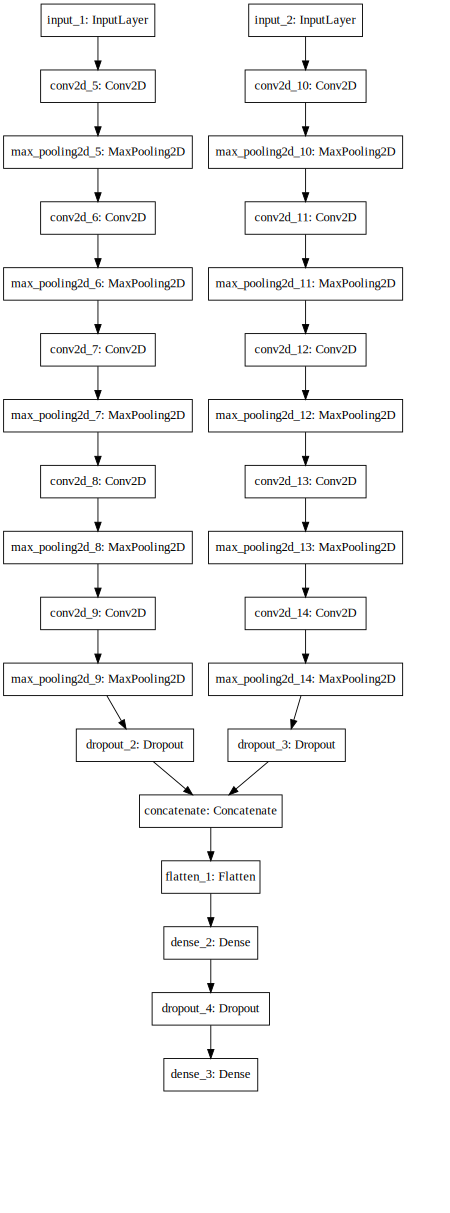

In [99]:
SVG(model_to_dot(model_grey, dpi = 65,rankdir = 'TB').create(prog='dot', format='svg'))

In [100]:
model_grey.fit([X_train_org_grey,X_train_tag_grey], y_train_grey, batch_size=128, epochs=15, verbose=1,
           validation_data=([X_cv_org_grey,X_cv_tag_grey], y_cv_grey))

Train on 7496 samples, validate on 1125 samples
Epoch 1/15
7496/7496 [==============================] - ETA: 11:39 - loss: 0.6942 - accuracy: 0.492 - ETA: 8:14 - loss: 0.6924 - accuracy: 0.507 - ETA: 6:46 - loss: 0.6923 - accuracy: 0.50 - ETA: 6:03 - loss: 0.6921 - accuracy: 0.51 - ETA: 5:33 - loss: 0.6901 - accuracy: 0.53 - ETA: 5:11 - loss: 0.6877 - accuracy: 0.55 - ETA: 4:53 - loss: 0.6842 - accuracy: 0.58 - ETA: 4:39 - loss: 0.6802 - accuracy: 0.59 - ETA: 4:28 - loss: 0.6775 - accuracy: 0.59 - ETA: 4:17 - loss: 0.6741 - accuracy: 0.59 - ETA: 4:09 - loss: 0.6677 - accuracy: 0.61 - ETA: 4:01 - loss: 0.6628 - accuracy: 0.61 - ETA: 3:53 - loss: 0.6569 - accuracy: 0.62 - ETA: 3:46 - loss: 0.6523 - accuracy: 0.62 - ETA: 3:39 - loss: 0.6436 - accuracy: 0.63 - ETA: 3:33 - loss: 0.6351 - accuracy: 0.64 - ETA: 3:27 - loss: 0.6292 - accuracy: 0.64 - ETA: 3:21 - loss: 0.6171 - accuracy: 0.65 - ETA: 3:15 - loss: 0.6103 - accuracy: 0.66 - ETA: 3:08 - loss: 0.6019 - accuracy: 0.67 - ETA: 3:02 - l

7496/7496 [==============================] - ETA: 4:42 - loss: 0.0564 - accuracy: 0.97 - ETA: 4:23 - loss: 0.0576 - accuracy: 0.97 - ETA: 4:26 - loss: 0.0793 - accuracy: 0.96 - ETA: 4:20 - loss: 0.0738 - accuracy: 0.97 - ETA: 4:12 - loss: 0.0660 - accuracy: 0.97 - ETA: 4:07 - loss: 0.0752 - accuracy: 0.97 - ETA: 4:04 - loss: 0.0718 - accuracy: 0.97 - ETA: 4:03 - loss: 0.0681 - accuracy: 0.97 - ETA: 4:02 - loss: 0.0780 - accuracy: 0.97 - ETA: 3:54 - loss: 0.0767 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:41 - loss: 0.0784 - accuracy: 0.97 - ETA: 3:34 - loss: 0.0808 - accuracy: 0.97 - ETA: 3:32 - loss: 0.0830 - accuracy: 0.97 - ETA: 3:27 - loss: 0.0825 - accuracy: 0.97 - ETA: 3:21 - loss: 0.0807 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0816 - accuracy: 0.97 - ETA: 3:12 - loss: 0.0788 - accuracy: 0.97 - ETA: 3:08 - loss: 0.0819 - accuracy: 0.97 - ETA: 3:08 - loss: 0.0852 - accuracy: 0.97 - ETA: 3:04 - loss: 0.0827 - accuracy: 0.97 - ETA: 2:59 - loss: 0.0848 - accu

7496/7496 [==============================] - ETA: 4:11 - loss: 0.0576 - accuracy: 0.97 - ETA: 4:05 - loss: 0.0696 - accuracy: 0.97 - ETA: 4:01 - loss: 0.0612 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0521 - accuracy: 0.98 - ETA: 3:52 - loss: 0.0552 - accuracy: 0.97 - ETA: 3:49 - loss: 0.0534 - accuracy: 0.98 - ETA: 3:45 - loss: 0.0524 - accuracy: 0.97 - ETA: 3:40 - loss: 0.0486 - accuracy: 0.98 - ETA: 3:35 - loss: 0.0452 - accuracy: 0.98 - ETA: 3:31 - loss: 0.0451 - accuracy: 0.98 - ETA: 3:26 - loss: 0.0477 - accuracy: 0.98 - ETA: 3:22 - loss: 0.0480 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0464 - accuracy: 0.98 - ETA: 3:13 - loss: 0.0460 - accuracy: 0.98 - ETA: 3:08 - loss: 0.0450 - accuracy: 0.98 - ETA: 3:04 - loss: 0.0457 - accuracy: 0.98 - ETA: 3:00 - loss: 0.0446 - accuracy: 0.98 - ETA: 2:55 - loss: 0.0450 - accuracy: 0.98 - ETA: 2:51 - loss: 0.0431 - accuracy: 0.98 - ETA: 2:47 - loss: 0.0420 - accuracy: 0.98 - ETA: 2:42 - loss: 0.0425 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0418 - accu

In [101]:
test_score3, test_acc3 = model_grey.evaluate([X_test_org_grey,X_test_tag_grey],y_test_grey)

750/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 10s 14ms/sample - loss: 0.0537 - accuracy: 0.9813


In [102]:
print('Test accuracy is:', test_acc3)
print('Test score is :', test_score3)

Test accuracy is: 0.9813333
Test score is : 0.08258702615896861


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       374
           1       0.97      1.00      0.98       376

    accuracy                           0.98       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.98      0.98      0.98       750



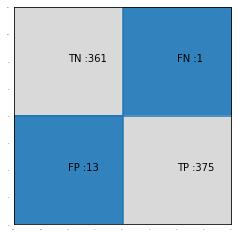

accuracy is : 0.9813333333333333
F1 score is : 0.981675392670157
Miss rate is : 0.0026595744680851063
NPV is : 0.9972375690607734


Error rate : 0.018666666666666668
Sensitivity / Recall : 0.9973404255319149
Specificity : 0.9652406417112299
Precision : 0.9664948453608248
False positive rate : 0.034759358288770054


In [103]:
yhat_test_grey_pred = model_grey.predict([X_test_org_grey,X_test_tag_grey]) #predict_classes doesn't work for non sequential, returns % chance
yhat_test_grey = np.around(yhat_test_grey_pred).flatten().astype(int) #Round to 0 or 1 depending on prediction

generate_confusion_matrix(y_test_grey,yhat_test_grey)

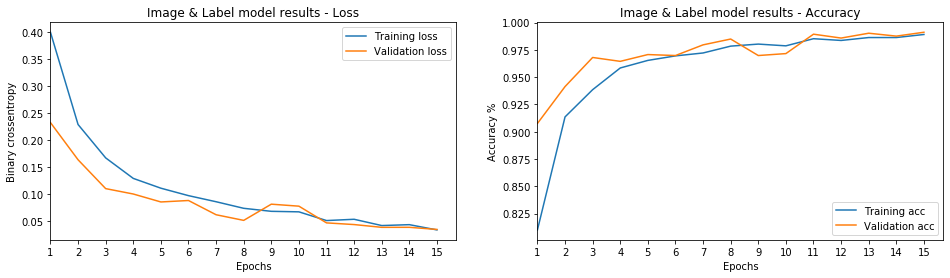

In [114]:
model_graphs(model_grey)

In [108]:
randomizer = np.random.choice(X_train_tag_grey.shape[0], 100, replace=False)
background = [X_train_org_grey[randomizer],X_train_tag_grey[randomizer]]

# # explain predictions of the model on several images
e = shap.GradientExplainer(model_grey, background) #Deep Explainer doesn't work yet for tf 2.0
B = np.block([yhat_test_grey[:,np.newaxis],y_test_grey[:,np.newaxis]])
print(np.where(np.sum(B,axis=1) == 1 )[0]) #Get misclassifications

labels_org_grey = y_test_grey[326:334] + yhat_test_grey[326:334]/10
labels_org_grey

[ 26  73  95 173 192 273 313 320 326 333 425 597 675 725]


array([0.1, 0. , 0. , 1.1, 1.1, 1.1, 1.1, 0.1])

In [109]:
#We look at images predicted as no plaque and plaque
shap_values = e.shap_values([X_test_org_grey[326:334],X_test_tag_grey[326:334]])

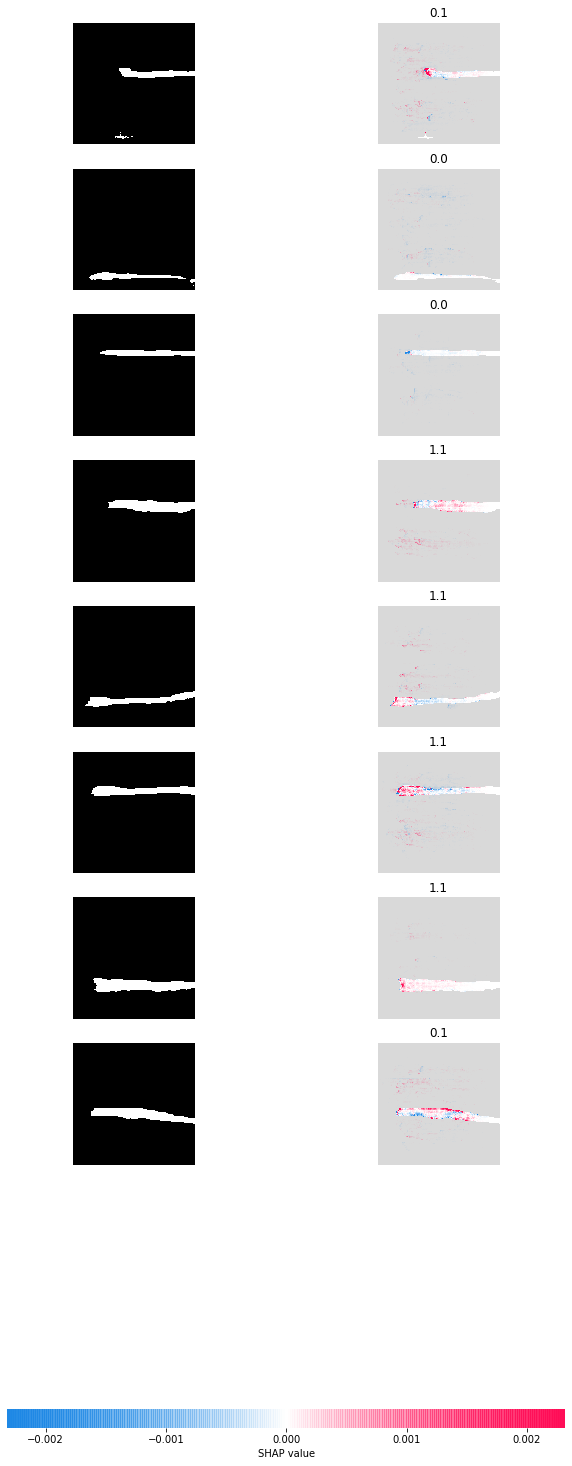

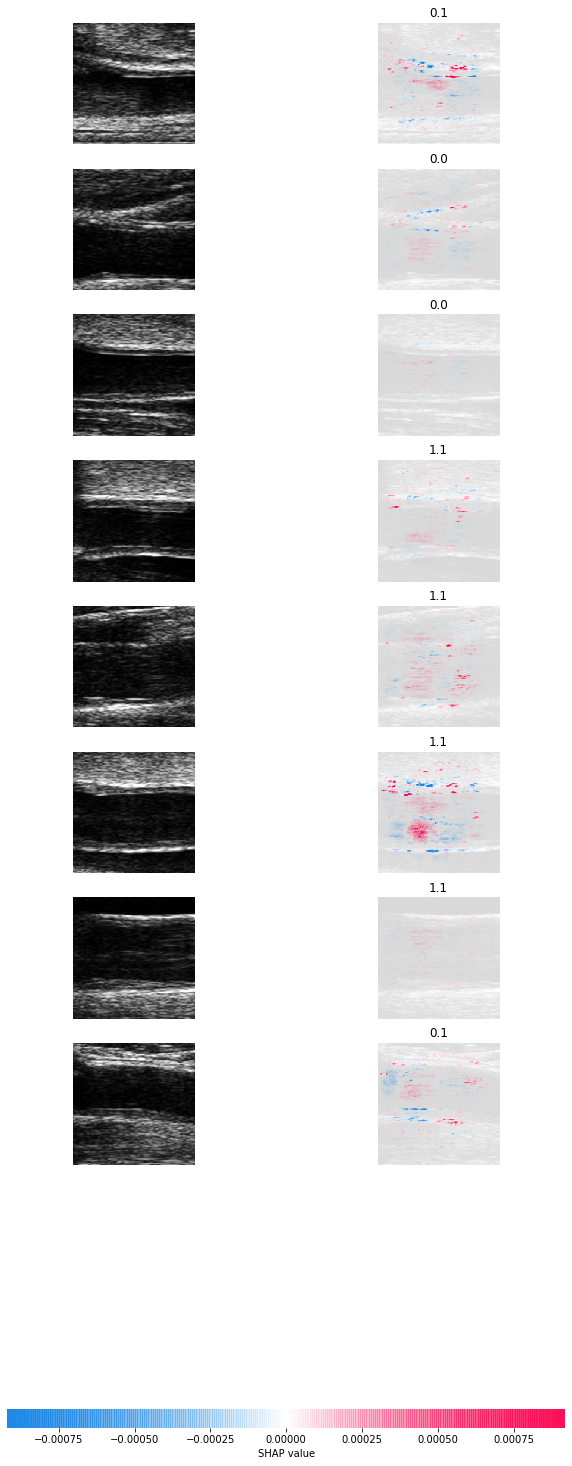

In [113]:
#Get one explanation for each input (in this case 2), and a len of 1 on shap values for 1 output
shap.image_plot([shap_values[0][1]], X_test_tag_grey[326:334],labels = labels_org_grey[:,np.newaxis],show = False) #Tag
fig = plt.gcf()
fig.set_size_inches((10, 30))

shap.image_plot([shap_values[0][0]], X_test_org_grey[326:334],labels = labels_org_grey[:,np.newaxis],show = False) #Orginals
fig = plt.gcf()
fig.set_size_inches((10, 30))